# Natural Language Processing Song Lyrics

<!--**Goal.** Use machine learning to predict the mood of music from song lyrics and audio features.-->

The following project aims to extract and analyze insightful data about songs from a specified playlist on Spotify using the Spotify Web API. Subsequently, the `lyricsgenius` package allows for web scraping of the Genius Lyrics website to extract the lyrics for each song. Following extraction, the lyrics are thoroughly cleaned before undergoing sentiment analysis.



## Extracting Spotify Data

Getting started, we want to extract data for a set of tracks within one of Spotify's top-featured playlists. Leveraging the **Spotify Web API**, we can seamlessly obtain detailed data for a song, such as the performing artist, the album it belongs to, its release date, popularity, and audio features like danceability, energy, and tempo. 

Python libraries like `spotipy` offer a user-friendly way to interact with the Spotify API, offering a range of functions that streamline tasks like API authentication, retrieving playlist data, and obtaining information about any given song.


### Accessing the Spotify Web API

To access data from Spotify, we import the `spotipy` library and the `SpotifyClientCredentials` module. Additionally, we utilize the `pandas` package for data manipulation and display. In order to authenticate our access to the Spotify API, we must provide our **client ID** and **client secret** to a client credentials manager. Once authenticated, we can use the spotipy module to interact with the Spotify API and retrieve data.


In [73]:
#| code-annotations: hover

import spotipy  # <1>
from spotipy.oauth2 import SpotifyClientCredentials # <1>
import pandas as pd # <1>

client_id = "xxx" # <2>
client_secret = "xxx" # <2>
my_auth = SpotifyClientCredentials(client_id, client_secret) # <3>
sp = spotipy.Spotify(auth_manager=my_auth) # <4>

In [74]:
client_id = "3899576b5fcb4c458beba2cce99aa1b6"
client_secret = "092a0b9b1e074abba82ce61ba6137aea"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret))

#### Spotify's Featured Playlists

Let's take a look at the popular Spotify playlists. Below, the code retrieves a range of Spotify playlists and generates a dataframe containing details for each playlist, such as its name, ID, description, thumbnail, and total number of tracks. The resulting dataframe is displayed as an HTML table.

In [75]:
username = "spotify"
my_playlists = sp.user_playlists(username)

In [130]:
from IPython.core.display import HTML

playlist_df = []
# Loop through list of response dictionaries
for item in my_playlists["items"]:
    playlist_id = item["id"]
    playlist_name = item["name"]
    description = item["description"]
    thumbnail = item["images"][0]["url"]
    total = item["tracks"]["total"]
    playlist_df.append([thumbnail, playlist_name, playlist_id, description, total])

playlist_df = pd.DataFrame(playlist_df, columns=["thumbnail", "playlist_name", "playlist_id", "description", "total"], ).head()

# Converting links to html tags
def path_to_image_html(path):
    return f'<img src="{path}" width="40" >'

# Rendering the dataframe as HTML table
HTML(playlist_df.to_html(escape=False, formatters=dict(thumbnail=path_to_image_html)))

---------------------

### Extracting Tracks From a Playlist

The following script enables the compilation of song and artist data from any Spotify playlist through its URI. To analyze a particular playlist, simply copy the URI from the Spotify Player interface and input it into the function defined below. The `get_playlist_tracks` method returns a complete list of track IDs and corresponding artists from the selected playlist.

In [77]:
def get_playlist_tracks(playlist_URI):
    tracks = []
    results = sp.playlist_tracks(playlist_URI)
    tracks = results["items"]
    while results["next"]:
        results = sp.next(results)
        tracks.extend(results["items"])
    return tracks

#### Extracting Features from Tracks


The following script utilizes Spotify's API to extract further details about each song within the playlist. It obtains metadata such as the track name, the artist it's sung by, the album it belongs to, the release date, and track features such as danceability, tempo, and popularity.


In [79]:
#| code-fold: true

# Get playlist song features and artist info
def playlist_features(id, artist_id, playlist_id):
    
    # Create Spotify API client variables
    meta = sp.track(id)
    audio_features = sp.audio_features(id)
    artist_info = sp.artist(artist_id)
    playlist_info = sp.playlist(playlist_id)

    # Metadata
    name = meta['name']
    track_id = meta['id']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    artist_id = meta['album']['artists'][0]['id']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # Main artist name, popularity, genre
    artist_pop = artist_info["popularity"]
    artist_genres = artist_info["genres"]

    # Track features
    acousticness = audio_features[0]['acousticness']
    danceability = audio_features[0]['danceability']
    energy = audio_features[0]['energy']
    instrumentalness = audio_features[0]['instrumentalness']
    liveness = audio_features[0]['liveness']
    loudness = audio_features[0]['loudness']
    speechiness = audio_features[0]['speechiness']
    tempo = audio_features[0]['tempo']
    valence = audio_features[0]['valence']
    key = audio_features[0]['key']
    mode = audio_features[0]['mode']
    time_signature = audio_features[0]['time_signature']
    
    # Basic playlist info
    playlist_name = playlist_info['name']

    return [name, track_id, album, artist, artist_id, release_date, length, popularity, 
            artist_pop, artist_genres, acousticness, danceability, 
            energy, instrumentalness, liveness, loudness, speechiness, 
            tempo, valence, key, mode, time_signature, playlist_name]

In [112]:
playlist_URI = "37i9dQZF1DXcBWIGoYBM5M"  # Spotify playlist URI
all_tracks = [  # Loop over track ids
    playlist_features(i["track"]["id"], i["track"]["artists"][0]["uri"], playlist_URI)
    for i in get_playlist_tracks(playlist_URI)
]

Putting it all together, the `get_playlist_tracks` function retrieves basic details for each song in a specified Spotify playlist using its URI. The `playlist_features` function then iterates through these tracks using their IDs to extract additional information, such as danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and more. From there, we create a Pandas dataframe by passing in the extracted information.

In [167]:
# Create dataframe
df = pd.DataFrame(
    all_tracks, columns=['name', 'track_id', 'album', 'artist', 'artist_id','release_date',
                     'length', 'popularity', 'artist_pop', 'artist_genres',
                     'acousticness', 'danceability', 'energy',
                     'instrumentalness', 'liveness', 'loudness',
                     'speechiness', 'tempo', 'valence', 'key', 'mode',
                     'time_signature', 'playlist'])

df[['name', 'artist', 'release_date', 'popularity', 
    'artist_pop', 'artist_genres', 'acousticness', 
    'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'speechiness', 
    'tempo', 'valence', 'playlist']].tail(4)

name         artist release_date  popularity  \
46                        CUFF IT        Beyoncé   2022-07-29          88   
47                   Here With Me           d4vd   2023-05-26          91   
48                     Last Night  Morgan Wallen   2023-01-31          89   
49  Dial Drunk (with Post Malone)     Noah Kahan   2023-07-18          87   

    artist_pop               artist_genres  acousticness  danceability  \
46          85                  [pop, r&b]        0.0368         0.780   
47          76  [bedroom pop, bedroom r&b]        0.5440         0.571   
48          87      [contemporary country]        0.4590         0.517   
49          80                [pov: indie]        0.1210         0.667   

    energy  instrumentalness  liveness  loudness  speechiness    tempo  \
46   0.689          0.000010    0.0698    -5.668       0.1410  115.042   
47   0.458          0.000093    0.1230    -9.283       0.0258  132.025   
48   0.675          0.000000    0.1510    -5.382       0.0357  203.853   
49   0.613          0.000000    0.1130    -7.147       0.0313  112.046   

    valence           playlist  
46    0.642  Today's Top Hits   
47    0.299  Today's Top Hits   
48    0.518  Today's Top Hits   
49    0.681  Today's Top Hits


----




In [117]:
## Set Default Plot Chart Style Configurations
from IPython.display import set_matplotlib_formats
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (8, 5) # Set default figure size.
plt.rc('font', family='Roboto') # Set default font family

pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})

#### Top Artist Genres


The following code generates a dictionary that contains the frequency of artist genres, which is then converted into a dataframe sorted by tallying the number of occurrences of each genre The resulting dataframe exhibits the genres and the number of times they occur.

In [82]:
#| code-fold: true

genres_dict = {}
for x in df.artist_genres:
    for ii in x:
        if ii in genres_dict:
            genres_dict[ii] += 1
        else:
            genres_dict[ii] = 1

# Convert Dictionary to Dataframe
df_genres = pd.DataFrame(genres_dict.items(), columns=['Genre', 'Freq']).sort_values('Freq', ascending=False)
df_genres = df_genres.reset_index(drop = True)

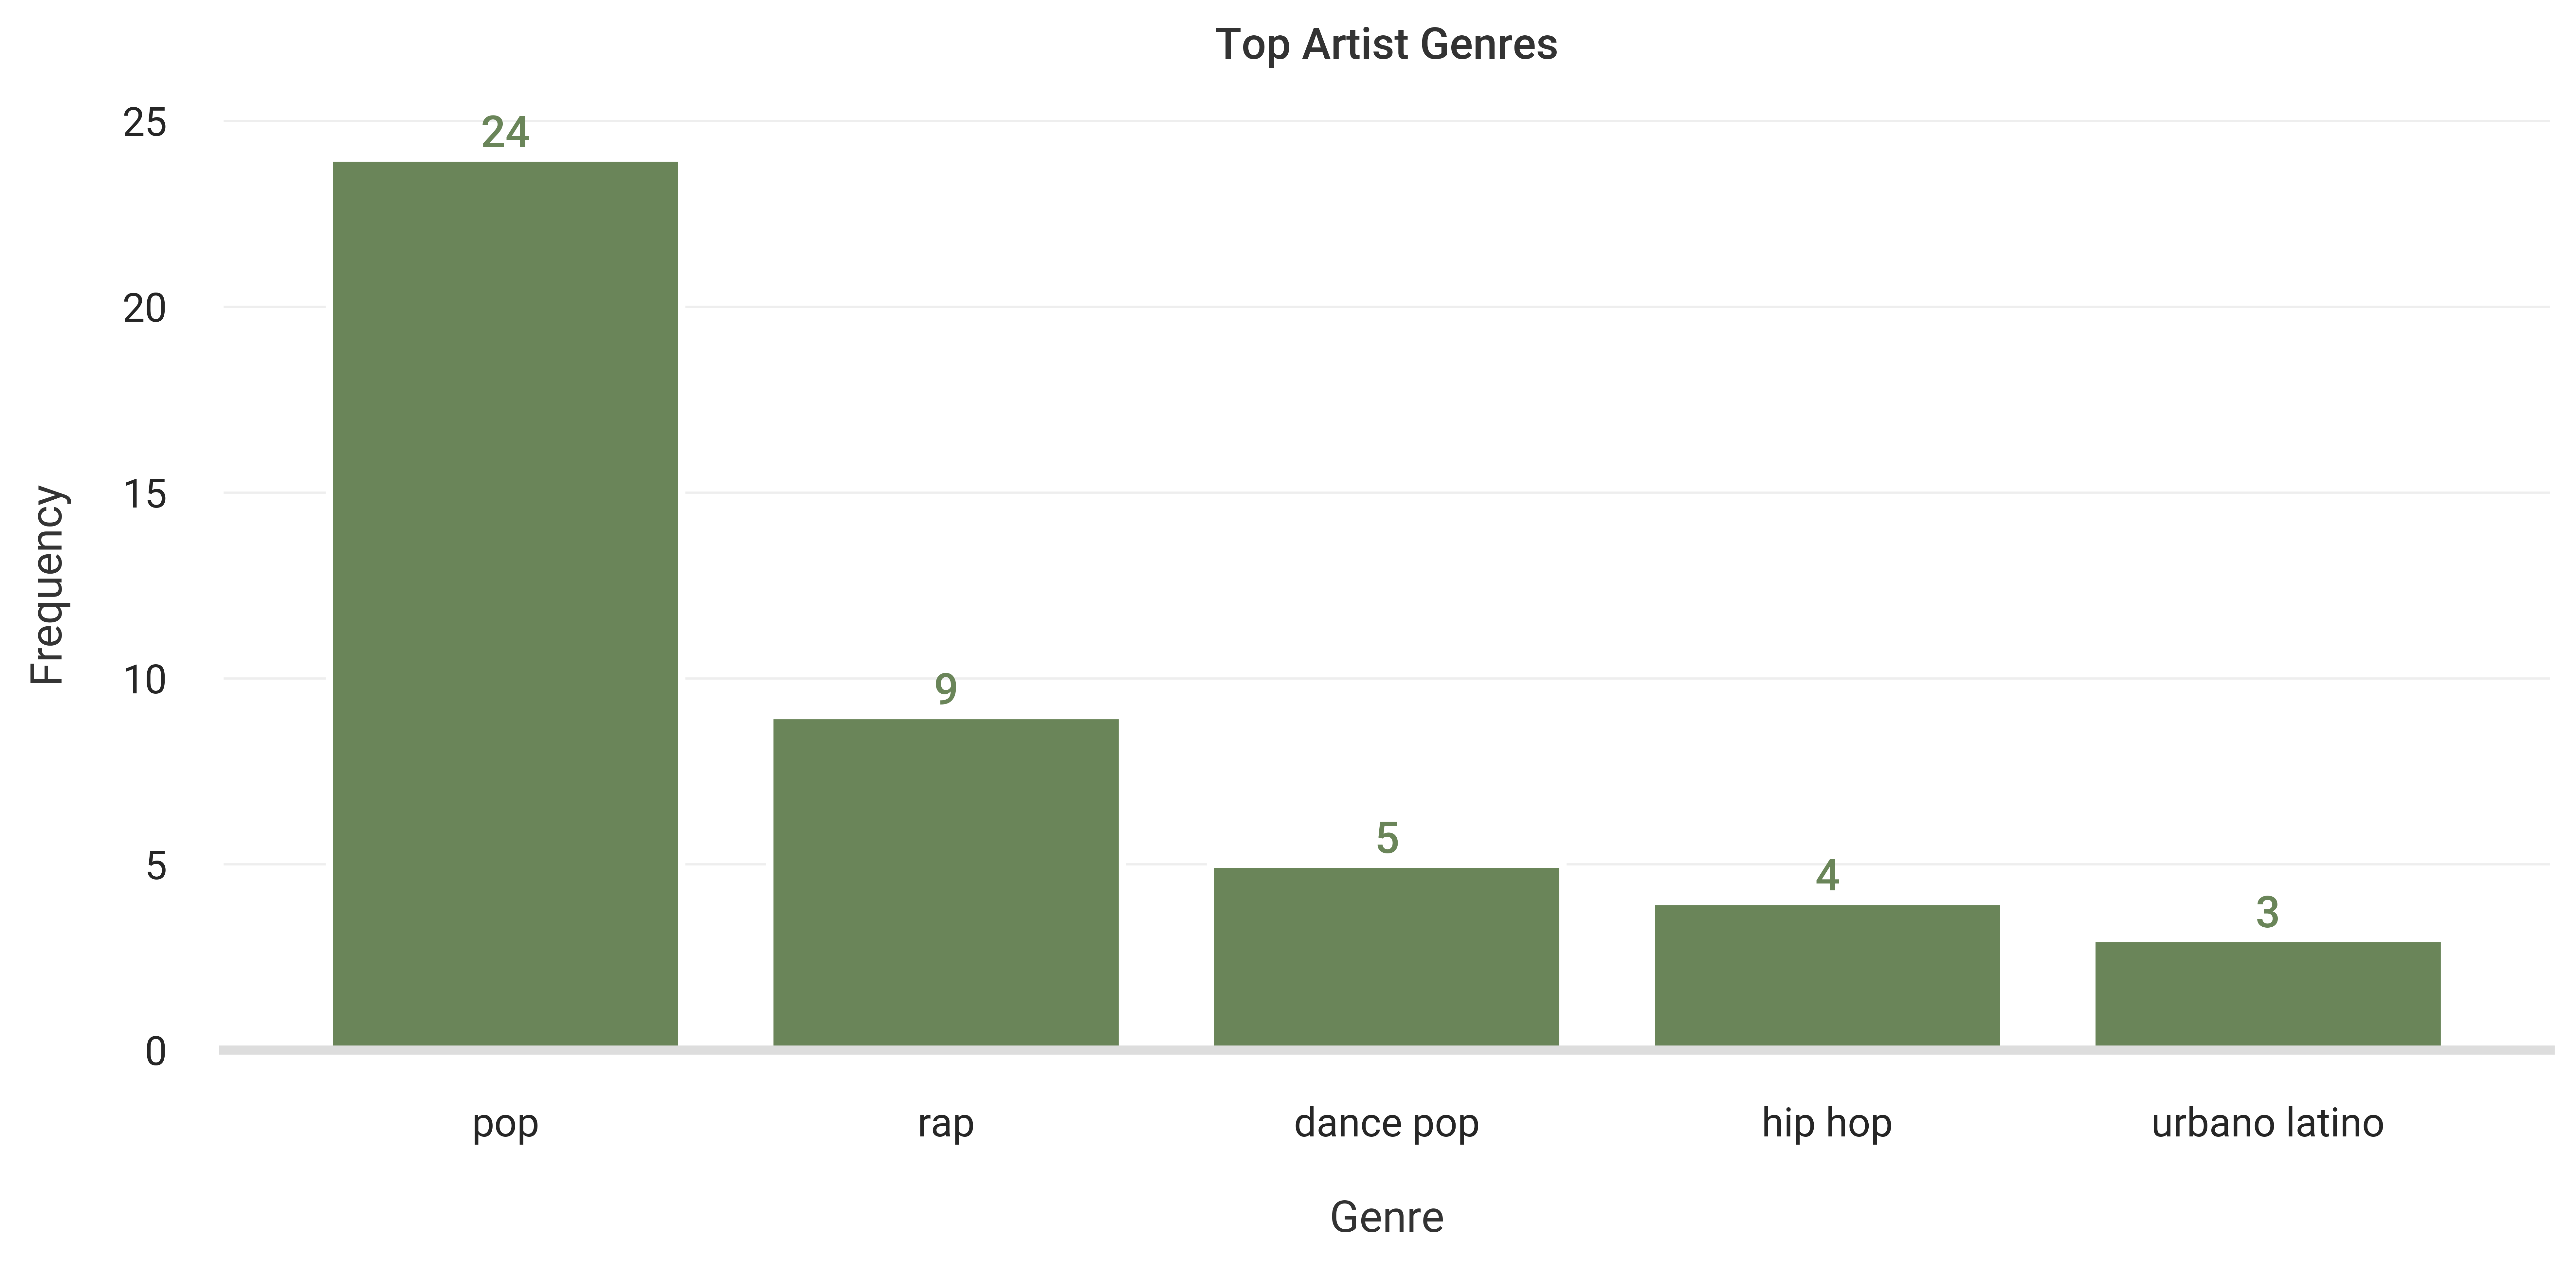

In [168]:
fig, ax = plt.subplots(figsize = (10,5), dpi =400)

# Save the chart so we can loop through the bars below.
bars = ax.bar(x=df_genres.head()['Genre'], height=df_genres.head()['Freq'],color="#6A8559")

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('Genre', labelpad=15, color='#333333')
ax.set_ylabel('Frequency', labelpad=15, color='#333333')
ax.set_title('Top Artist Genres', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()
# plt.savefig("static/images/artist_genres.png", format="png", dpi=1200)

In [172]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

df_genres2 = df_genres.head(15)

-------


## Natural Language Processing

Using the data gathered from the Spotify API, we now want to extract and process the lyrics for each song. This is accomplished through scraping textual information, namely lyrical data, from the **Genius Lyrics** website. Following extraction, the lyrics are thoroughly processed and cleaned before undergoing sentiment analysis. 



<!--### Scraping the Genius Lyrics Website
scraping textual information
Scraping the Genius Lyrics Website-->




### Scraping the Web

To get started, the script below imports `lyricsgenius`, a fundamental package libary allowing for web scraping of the Genius Lyrics website to retrieve the lyrics of any given song. Through the initialization of the `genius` variable, one can access the Genius API and retrieve the lyrics of any given song, such as "Too Many Nights" by Metro Boomin.


In [16]:
import lyricsgenius

genius = lyricsgenius.Genius("epFCxujgBe-Y6WrkZedI8kerKxiCpR6Rh0DAHYNlKDf9B4H1nXTdZIkj7krNUHVV")
song = genius.search_song("Too Many Nights", "Metro Boomin")

Searching for "Too Many Nights" by Metro Boomin...
Done.


<!--#### Regex and Profanity Filter-->


The function provided below is designed to efficiently fetch the lyrics of a song using the given track name and artist. Once the lyrics are retrieved, the next step is to pre-process the textual data. This involves a cleansing process to eliminate profanity, specific characters, and patterns that may hinder the overall readability. The resulting output is a list of cleaned lyrics with all non-ASCII characters removed.

In [17]:
#| code-fold: true

import re
import contractions
import string
from better_profanity import profanity
from nltk.tokenize import word_tokenize
#from profanity import profanity
#from better_profanity import profanity as profanity2

First, we define a function that retrieves the lyrics for any song and artist from the Genius database. As shown below, it first searches for the track using the provided name and artist and then extracts the lyrics from the search results.

In [18]:
def get_song_lyrics(song_name, song_artist):
    song_genius = genius.search_song(song_name, song_artist)
    song_lyrics = song_genius.lyrics.partition("Lyrics")[2]
    # Remove any numbers followed by 'Embed'
    song_lyrics = re.sub(r"[\[].*?[\]]|\d+Embed", "", song_lyrics)
    # Remove text between square brackets
    song_lyrics = re.sub(r"(\-[A-Za-z]+\-)", "", song_lyrics)

    return song_lyrics

### Pre-Processing Text Data

The following Python script contains various functions optimized for efficiently cleaning song lyrics, which is a crucial step towards building a sentiment classifier. The text pre-processing procedure involves the following main steps.

1. Language Detection
2. Expanding Contractions
3. Converting Text to Lowercase
4. Spell Checking + Censoring
5. Removing Punctuations
6. Tokenization

The function `detect_and_translate` below is designed to identify and translate text into a specified language, specifically English. It first checks the language of the original text and compares it to the target language. If the detected language differs from the target language, the function utilizes GoogleTranslator to translate the input text into the target language (English).


In [19]:
from deep_translator import GoogleTranslator
from langdetect import detect

In [20]:
# Function to detect and translate text
def detect_and_translate(track_lyrics, target_lang):
    result_lang = detect(track_lyrics)
    if result_lang == target_lang:
        return track_lyrics
    # translate_text
    translator = GoogleTranslator(source="auto", target="en")
    return translator.translate(track_lyrics)

We also develop various functions to support the preprocessing of textual data, streamlining the process and improving the accuracy of the final output. Among these functions are a method for removing punctuation from a given string of lyrics and a spell-checker that automatically finds and corrects any spelling errors.


In [21]:
#| code-fold: true

def remove_punctuation(clean_lyrics_str):
    punctuations = string.punctuation  # define punctuation
    no_punct = ""
    for char in clean_lyrics_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct  # return unpunctuated string

In [22]:
# | code-fold: true
# Spell Check + Censor
from spellchecker import SpellChecker
from tkinter import *

spell = SpellChecker()

def spell_check(word_list_str):
    word_corrected_list = []
    for word in word_list_str.split():
        word_corrected = spell.correction(word)
        if word_corrected is not None:
            word_corrected_list.append(word_corrected)
        else:
            word_corrected_list.append(word)
    return word_corrected_list

As follows, the `clean_song_lyrics` function is specifically designed to process textual lyrics for a particular song and artist. The process begins by retrieving the lyrics from the Genius database and translating them into English if needed. The next step involves expanding contractions, removing redundant expressions like "lala" or "nanana", and converting the lyrics to lowercase. Next, it performs a spell check to correct any spelling errors, censors any profanity language, and removes all punctuation. Once the processing is complete, the function tokenizes and encodes the cleaned text, returning the decoded lyrics as a list of words. The result is a beautifully processed set of lyrics, tokenized and decoded as a list of words. 


In [23]:
#| code-annotations: hover

def clean_song_lyrics(song_name, artist_name):
    genius_lyrics = get_song_lyrics(song_name, artist_name) # <1>
    lyrics_en = detect_and_translate(genius_lyrics, "en")  # <2> 
    
    no_contract = [contractions.fix(word) for word in lyrics_en.split()] # <3>
    no_contract_str = " ".join(no_contract).lower()  # lowercase # <4>
    no_contract_str = re.sub(r"nana|lala", "", no_contract_str) # <4>
    
    corrected = spell_check(no_contract_str) # <5> # Spell Check + Censor
    censored = profanity.censor(" ".join(corrected), censor_char="") # <5>
    no_punct = remove_punctuation(censored) # <6> # Remove Punctuation
    
    tokenized = word_tokenize(no_punct)  # Tokenize # <7>
    strencode = [i.encode("ascii", "ignore") for i in tokenized]  # Encode() method # <8>
    return [i.decode() for i in strencode]  # Decode() method # <8>


1. Gather lyrics from the Genius database
2. Translate the lyrics into English if needed
3. Expand contractions 
4. Convert to lowercase and remove redundant expressions like "lala" or "nanana"
5. Perform a spell check and censor any profanity language 
6. Remove all punctuation
7. Tokenize each word
8. Encode the cleaned text, returning the decoded lyrics as a list of words

The result is a beautifully processed set of lyrics, tokenized and decoded as a list of words. 


#### Removing Stop Words

The code below aims to eliminate stopwords from lyrics utilizing the **Natural Language Toolkit** (NLTK) library and its `WordNetLemmatizer` tool. The removal of stopwords is particularly beneficial in natural language processing tasks, such as sentiment analysis or topic modeling. By eliminating frequently occurring words like "the," "and," or "of," the resulting text becomes more compact and meaningful. Without the distraction of stopwords, the analysis can more effectively capture the essence of the lyrics and the underlying conveyed message. This process allows researchers and developers to gain valuable insights and draw accurate conclusions from textual data. Whether it is exploring song lyrics, analyzing customer reviews, or studying social media trends, removing stopwords enhances the quality of text analysis and facilitates more efficient information extraction.



In [24]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [25]:
def remove_stopwords_lyrics(clean_lyrics_decode):
    stopword = stopwords.words("english")
    stopword.extend(["yeah", "nanana", "nana", "oh", "la"])
    return [word for word in clean_lyrics_decode if word not in stopword]

#### Lemmatization



Next, we define a function to perform lemmatization on a set of words using the WordNetLemmatizer class from the NLTK library. Lemmatization is a crucial step in natural language processing and text analysis, helping to standardize words and reduce their complexity. By reducing words to their root or base form, lemmatization enables more accurate analysis and comparisons. Our function specifically targets verbs and transforms different variations of the same verb into its most basic form.




In [26]:
# | code-fold: true

from nltk.corpus import stopwords, wordnet

def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

First, the following script determines the part of speech (i.e., noun, verb, adverb, etc.) for each word in the provided lyrics and assigns an appropriate tag. Then, we write a function, as shown above, that converts the parts of speech tag to WordNet's format. With this function, we apply the conversion within a list comprehension setup. Finally, we apply the NLTK's word lemmatizer to each word. 


In [27]:
from nltk.tag import pos_tag
from nltk import pos_tag

def word_lemmatize(lyrics_cleaned):  # clean_lyrics_decode):
    pos_tags = pos_tag(lyrics_cleaned)
    wordnet_pos = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tags]

    wnl = WordNetLemmatizer()  # Lemmatize Lyrics
    # return [wnl.lemmatize(word, "v") for word in clean_lyrics_decode]
    return [wnl.lemmatize(word, tag) for word, tag in wordnet_pos]

In summary, the code above defines a function that makes use of the WordNetLemmatizer class from the NLTK library to conduct lemmatization specifically targeting verbs, thereby converting words to their most basic form.


#### Exploratory text analysis


Below is a code snippet that iterates through the "all_tracks" dataset, extracting each track name and the corresponding artist. We then apply our pre-defined functions to clean the lyrics, remove stopwords, and perform lemmatization for each song. Specifically, we execute the `clean_song_lyrics()` function, passing in the extracted song name and artist name. We then proceed to call the `remove_stopwords_lyrics()` and `word_lemmatize()` functions, both of which take in the cleaned lyrics string from the previous step as input.


In [28]:
from nltk.tag import pos_tag

dict_ls = []

for i in range(len(df)):
    song_name = df["name"][i].partition(" (")[0]
    song_name = song_name.partition(" [")[0]
    song_name = song_name.partition(" -")[0]
    artist_name = df["artist"][i]

    track_lyrics = clean_song_lyrics(song_name, artist_name)
    stopwords_removed = remove_stopwords_lyrics(track_lyrics)
    lemmatized = word_lemmatize(stopwords_removed)

    track_dict = {
        "track": song_name,
        "artist": artist_name,
        "lyrics": track_lyrics,
        "stopwords removed": stopwords_removed,
        "lemmatized words": lemmatized
    }

    dict_ls.append(track_dict)

Searching for "(It Goes Like) Nanana" by Peggy Gou...
Done.


Searching for "Barbie World" by Nicki Minaj...
Done.
Searching for "Paint The Town Red" by Doja Cat...
Done.
Searching for "Seven" by Jung Kook...
Done.
Searching for "bad idea right?" by Olivia Rodrigo...
Done.
Searching for "Cruel Summer" by Taylor Swift...
Done.
Searching for "Dance The Night" by Dua Lipa...
Done.
Searching for "What Was I Made For?" by Billie Eilish...
Done.
Searching for "Popular" by The Weeknd...
Done.
Searching for "Super Shy" by NewJeans...
Done.
Searching for "fukumean" by Gunna...
Done.
Searching for "LALA" by Myke Towers...
Done.
Searching for "vampire" by Olivia Rodrigo...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Chemical" by Post Malone...
Done.
Searching for "MELTDOWN" by Travis Scott...
Done.
Searching for "Calm Down" by Rema...
Done.
Searching for "Kill Bill" by SZA...
Done.
Searching for "WHERE SHE GOES" by Bad Bunny...
Done.
Searching for "All My Life" by Lil Durk...
Done.
Searching for "Flowers" by Miley Cyrus...
Done.


In [29]:
df_lyrics = pd.DataFrame(dict_ls)
df_lyrics.head()

track          artist  \
0  (It Goes Like) Nanana       Peggy Gou   
1           Barbie World     Nicki Minaj   
2     Paint The Town Red        Doja Cat   
3                  Seven       Jung Kook   
4        bad idea right?  Olivia Rodrigo   

                                              lyrics  \
0  [i, can, not, explain, i, got, a, feeling, tha...   
1  [i, am, always, yours, ooh, woah, stop, playin...   
2  [by, walk, on, by, walk, on, by, walk, on, by,...   
3  [weight, of, the, world, on, your, shoulders, ...   
4  [hey, have, not, heard, from, you, in, a, coup...   

                                   stopwords removed  \
0  [explain, got, feeling, erase, feeling, leave,...   
1  [always, ooh, woah, stop, playing, riot, bad, ...   
2  [walk, walk, walk, walk, said, said, would, ra...   
3  [weight, world, shoulders, kiss, waist, ease, ...   
4  [hey, heard, couple, months, right, calling, p...   

                                    lemmatized words  
0  [explain, get, feeling, erase, feeling, leave,...  
1  [always, ooh, woah, stop, play, riot, bad, lik...  
2  [walk, walk, walk, walk, say, say, would, rath...  
3  [weight, world, shoulder, kiss, waist, ease, m...  
4  [hey, hear, couple, month, right, call, phone,...

##### Term Frequency Analysis

Let's examine the most frequent words. NLTK offers a powerful library called "FreqDist" that helps us determine the occurrence of the most common terms in our corpus. Initially, we must transform our individual lists of tokenized lyrics into a comprehensive list of iterable tokens that encompasses all the lyrics collectively.

In [211]:
from nltk.probability import FreqDist

words = df_lyrics['lemmatized words']
#words = df_lyrics['stopwords removed']
# words = df_lyrics['lyrics']

allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)
mostcommon = FreqDist(allwords).most_common(35)

['explain', 'get', 'feeling', 'erase', 'feeling', 'leave', 'behind', 'something', 'mind', 'guess', 'go', 'like', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'explain', 'get', 'feeling', 'erase', 'feeling', 'leave', 'behind', 'something', 'mind', 'guess', 'go', 'like', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'see', 'peggy', 'liege', 'ticket', 'low', '191you', 'might', 'also', 'like', 'explain', 'get', 'feeling', 'erase', 'feeling', 'leave', 'behind', 'something', 'mind', 'guess', 'go', 'like', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'explain', 'get', 'feeling', 'erase', 'feeling', 'leave', 'behind', 'something', 'mind', 'guess', 'go', 'like', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'always', 'ooh', 'woah', 'stop', 'play', 'riot', 'bad', 'like', 'barbie', 'barbie', 'doll', 'still', 'want', 'party', 'party', 'pink', 'yvette', 'like', 'ready', 'bend', 'bend', 'ten', 'pull', 'ken', 'like', 'jazzed', 'stack', 'nicki', 'grrah', 'barbies', 'pretty', 'barbies', 'bad'

In [202]:
x_mostcommon, y_mostcommon = zip(*mostcommon)
fig = px.bar(x=x_mostcommon, y=y_mostcommon, text_auto='.2s',
            title="Term Frequency Analysis of Popular Lyrics",
            template='plotly_dark') # plotly_white
# fig.show()

In [203]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=x_mostcommon,
        y=y_mostcommon,
        text=y_mostcommon,
        marker_color="rgb(55, 83, 109)",  
        #orientation="h",
        textfont={"family": "Roboto", "size": 8, "color": "white"}
    )
)
fig.update_layout(
    title="Term Frequency Analysis of Popular Lyrics",
    title_font=dict(family="Roboto", size=17), #template="plotly_dark",
    xaxis=dict(title='Count',titlefont_size=12,tickfont_size=10),
    yaxis=dict(title='Frequency',titlefont_size=12,tickfont_size=12),
    barmode="group",
    bargap=0.15,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # gap between bars of the same location coordinate.
)
fig.update_traces(marker_color= '#6A8559', 
                  marker_line_color='#4E6241',
                  marker_line_width=1.25, opacity=0.996)

fig.show()

--------------


## Sentiment Analysis


Subsequently, the process involves the implementation of pipeline classes to carry out predictions using models accessible in the Hub. The code imports and employs multiple transformer models specifically designed for text classification and sentiment analysis. Specifically, the following procedure creates three distinct pipelines, each equipped with different models that facilitate the assessment of emotions and sentiment in textual content.


In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
import transformers
from transformers import pipeline
# import tensorflow as tf
# python -m pip install "tensorflow<2.11"
# python -m pip install "protobuf<3.2"

classifier1 = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
classifier2 = pipeline("text-classification",model='cardiffnlp/twitter-roberta-base-sentiment', return_all_scores=True)
classifier3 = pipeline("sentiment-analysis", return_all_scores=True)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


The `get_lyric_sentiment` function takes in pre-processed lyrics as input and produces a dictionary of sentiment scores. It leverages three distinct classifiers to calculate the scores and aggregates them into a final result. For instance, one of these classifiers is the *distilbert-base-uncased-emotion* model, specifically trained to detect "emotions in texts such as sadness, joy, love, anger, fear, and surprise".


In [35]:
def get_lyric_sentiment(cleaned_lyrics):
    x = ' '.join(cleaned_lyrics)
    prediction1 = classifier1(x, truncation = True)
    song_score = {i['label']: i['score'] for i in prediction1[0]}
    
    prediction2 = classifier2(x, truncation=True, max_length=512)
    for j in prediction2[0]:
        song_score[j['label']] = j['score']

    prediction3 = classifier3(x, truncation=True)
    for k in prediction3[0]:
        song_score[k['label']] = k['score']

    return song_score

If the lyric sequence contains more than 512 tokens, it will trigger an error message indicating an exception encountered in the 'embeddings' layer. However, we have implemented measures to properly manage lyric sequences that exceed 512 words in the function mentioned above.

---------------------


## Putting it All Together

To summarize, the code efficiently collects data and performs text analysis on every song in a playlist. Specifically, it systematically processes a list of tracks and corresponding artists while simultaneously conducting a thorough cleaning procedure on the lyrics. The cleaning process involves removing all nonessential characters, resulting in a more precise depiction of the song's content. The outcome is a comprehensive frequency analysis of each word in a song's lyrics, providing deeper insights into the overall conveyed message.

Additionally, the program computes a sentiment score for each song based on the lyrics, indicating whether the lyrics are positive, negative, or neutral. It also collects information about the song and artist, such as the release date, length, popularity, and genre. Finally, the program compiles all this information into a dataframe for further analysis.

After extracting the data, it is organized and presented in a Pandas DataFrame for easy viewing.

In [36]:
lyrics_dict = {}
dict_ls = []

for i in range(len(df)):
    song_name = df['name'][i].partition(' (')[0]
    artist_name = df['artist'][i]
    track_lyrics = clean_song_lyrics(song_name, artist_name)
    track_lyrics = remove_stopwords_lyrics(track_lyrics)
    
    for k in (track_lyrics):
        if k in lyrics_dict:
            lyrics_dict[k] += 1
        else:
            lyrics_dict[k] = 1
            
    sent_score = get_lyric_sentiment(track_lyrics)
    sent_score['track_name'] = song_name
    sent_score['artist_name'] = artist_name
    sent_score['release_date'] = df['release_date'][i]
    sent_score['length'] = df['length'][i]
    sent_score['popularity'] = df['popularity'][i]
    sent_score['artist_pop'] = df['artist_pop'][i]
    sent_score['artist_genres'] = df['artist_genres'][i]
    sent_score['acousticness'] = df['acousticness'][i]
    sent_score['danceability'] = df['danceability'][i]
    sent_score['energy'] = df['energy'][i]
    sent_score['instrumentalness'] = df['instrumentalness'][i]
    sent_score['liveness'] = df['liveness'][i]
    sent_score['loudness'] = df['loudness'][i]
    sent_score['speechiness'] = df['speechiness'][i]
    sent_score['tempo'] = df['tempo'][i]
    sent_score['valence'] = df['valence'][i]
    
    dict_ls.append(sent_score)

Searching for "(It Goes Like) Nanana - Edit" by Peggy Gou...


Done.
Searching for "Barbie World" by Nicki Minaj...
Done.
Searching for "Paint The Town Red" by Doja Cat...
Done.
Searching for "Seven" by Jung Kook...
Done.
Searching for "bad idea right?" by Olivia Rodrigo...
Done.
Searching for "Cruel Summer" by Taylor Swift...
Done.
Searching for "Dance The Night" by Dua Lipa...
Done.
Searching for "What Was I Made For? [From The Motion Picture "Barbie"]" by Billie Eilish...
Done.
Searching for "Popular" by The Weeknd...
Done.
Searching for "Super Shy" by NewJeans...
Done.
Searching for "fukumean" by Gunna...
Done.
Searching for "LALA" by Myke Towers...
Done.
Searching for "vampire" by Olivia Rodrigo...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Chemical" by Post Malone...
Done.
Searching for "MELTDOWN" by Travis Scott...
Done.
Searching for "Calm Down" by Rema...
Done.
Searching for "Kill Bill" by SZA...
Done.
Searching for "WHERE SHE GOES" by Bad Bunny...
Done.
Searching for "All My Life" by Lil Durk...
Done.
Searchi

In [37]:
df_final = pd.DataFrame(dict_ls)
df_final = df_final[['track_name', 'artist_name', 'release_date', 'length', 'popularity', 
         'artist_pop', 'artist_genres', 'acousticness', 'danceability', 'energy',
         'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
         'sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'LABEL_0',
         'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

df_final.to_csv("static/data/top_songs_us.csv", index=False)

In [38]:
df_final.head(3)

track_name  artist_name release_date  length  popularity  \
0  (It Goes Like) Nanana - Edit    Peggy Gou   2023-06-15  231545          93   
1                  Barbie World  Nicki Minaj   2023-06-23  109750          95   
2            Paint The Town Red     Doja Cat   2023-08-04  231750          91   

   artist_pop                        artist_genres  acousticness  \
0          73               [electra, float house]         0.120   
1          86  [hip pop, pop, queens hip hop, rap]         0.519   
2          84                     [dance pop, pop]         0.269   

   danceability  energy  ...       joy      love     anger      fear  \
0         0.671   0.876  ...  0.015183  0.000968  0.003207  0.003389   
1         0.770   0.580  ...  0.251172  0.007338  0.542800  0.078930   
2         0.868   0.538  ...  0.990045  0.002187  0.001797  0.000627   

   surprise   LABEL_0   LABEL_1   LABEL_2  NEGATIVE  POSITIVE  
0  0.000714  0.169231  0.776154  0.054616  0.993093  0.006907  
1  0.005181  0.306202  0.642930  0.050868  0.997746  0.002254  
2  0.001279  0.237302  0.653762  0.108936  0.996174  0.003826  

[3 rows x 27 columns]

In summary, the above code aims to collect and refine song lyrics by eliminating stopwords and conducting lemmatization. Subsequently, it employs pre-trained models for sentiment analysis to determine the prevailing emotion conveyed in the lyrics, providing valuable insights into the overall tone and message of the song.




### Visualizing the Data

Our next step involves visually representing the distribution of different track features, such as song popularity. To achieve this, we generate a histogram using the powerful `matplotlib` and `seaborn` libraries. The figure includes an informative title and labels. We color the histogram with $n$ bins to accurately represent the popularity distribution. Finally, we present the histogram using the `plt.show()` function.


In [39]:
## Set Default Plot Chart Style Configurations
from IPython.display import set_matplotlib_formats
import seaborn as sns

pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})

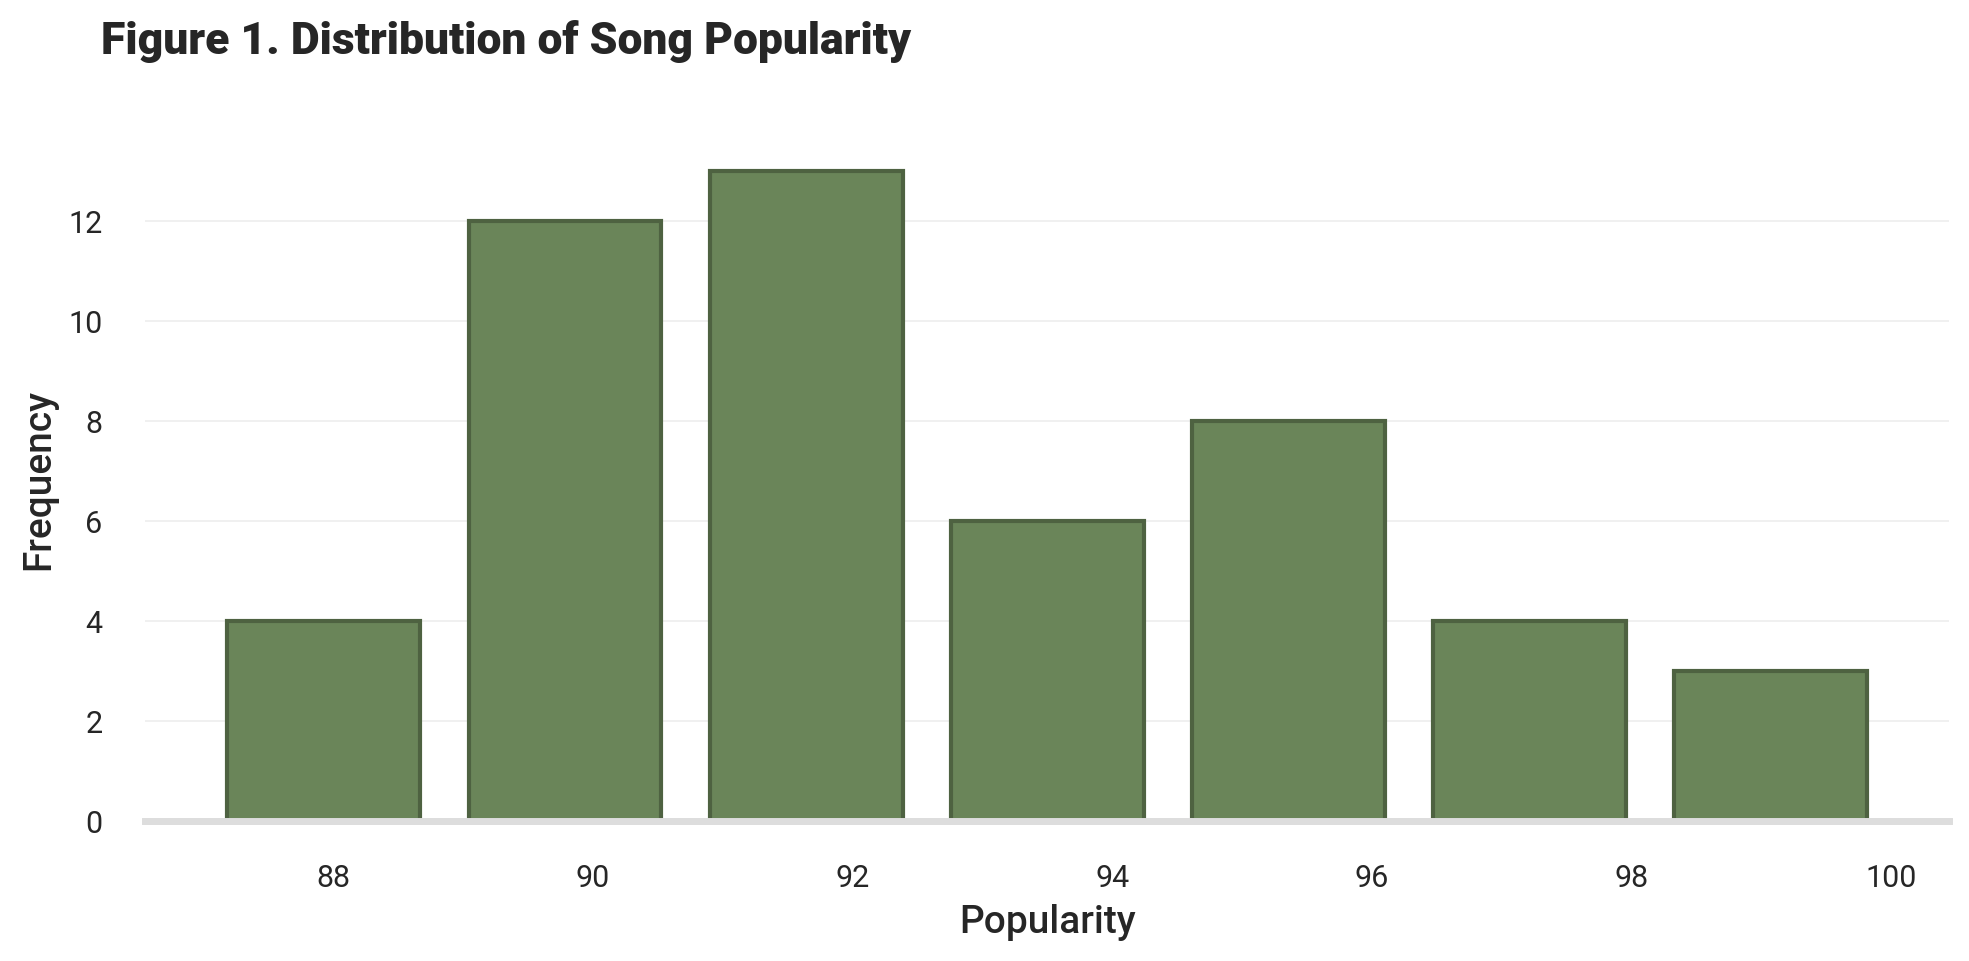

In [40]:
fig_hist = plt.figure(figsize = (10,5), dpi =100)
plt.title("Figure 1. Distribution of Song Popularity", weight='heavy',y =1.1, x=0.2).set_fontsize('16')
z = sns.histplot(data=df_final, x="popularity", color="#6A8559", alpha = 1.0, edgecolor="#4E6241", linewidth=1.5, shrink=.8)
sns.despine(left=True, bottom=False)
z.spines['bottom'].set_color('#DDDDDD')
z.yaxis.grid(True, color='#EEEEEE')
z.xaxis.grid(False)
plt.xlabel("Popularity", size=14, weight=500)
plt.ylabel("Frequency", size=14, weight=500)
plt.tight_layout()
# plt.savefig("static/images/hold_times_dist.png", format="png", dpi=1200)
plt.show()

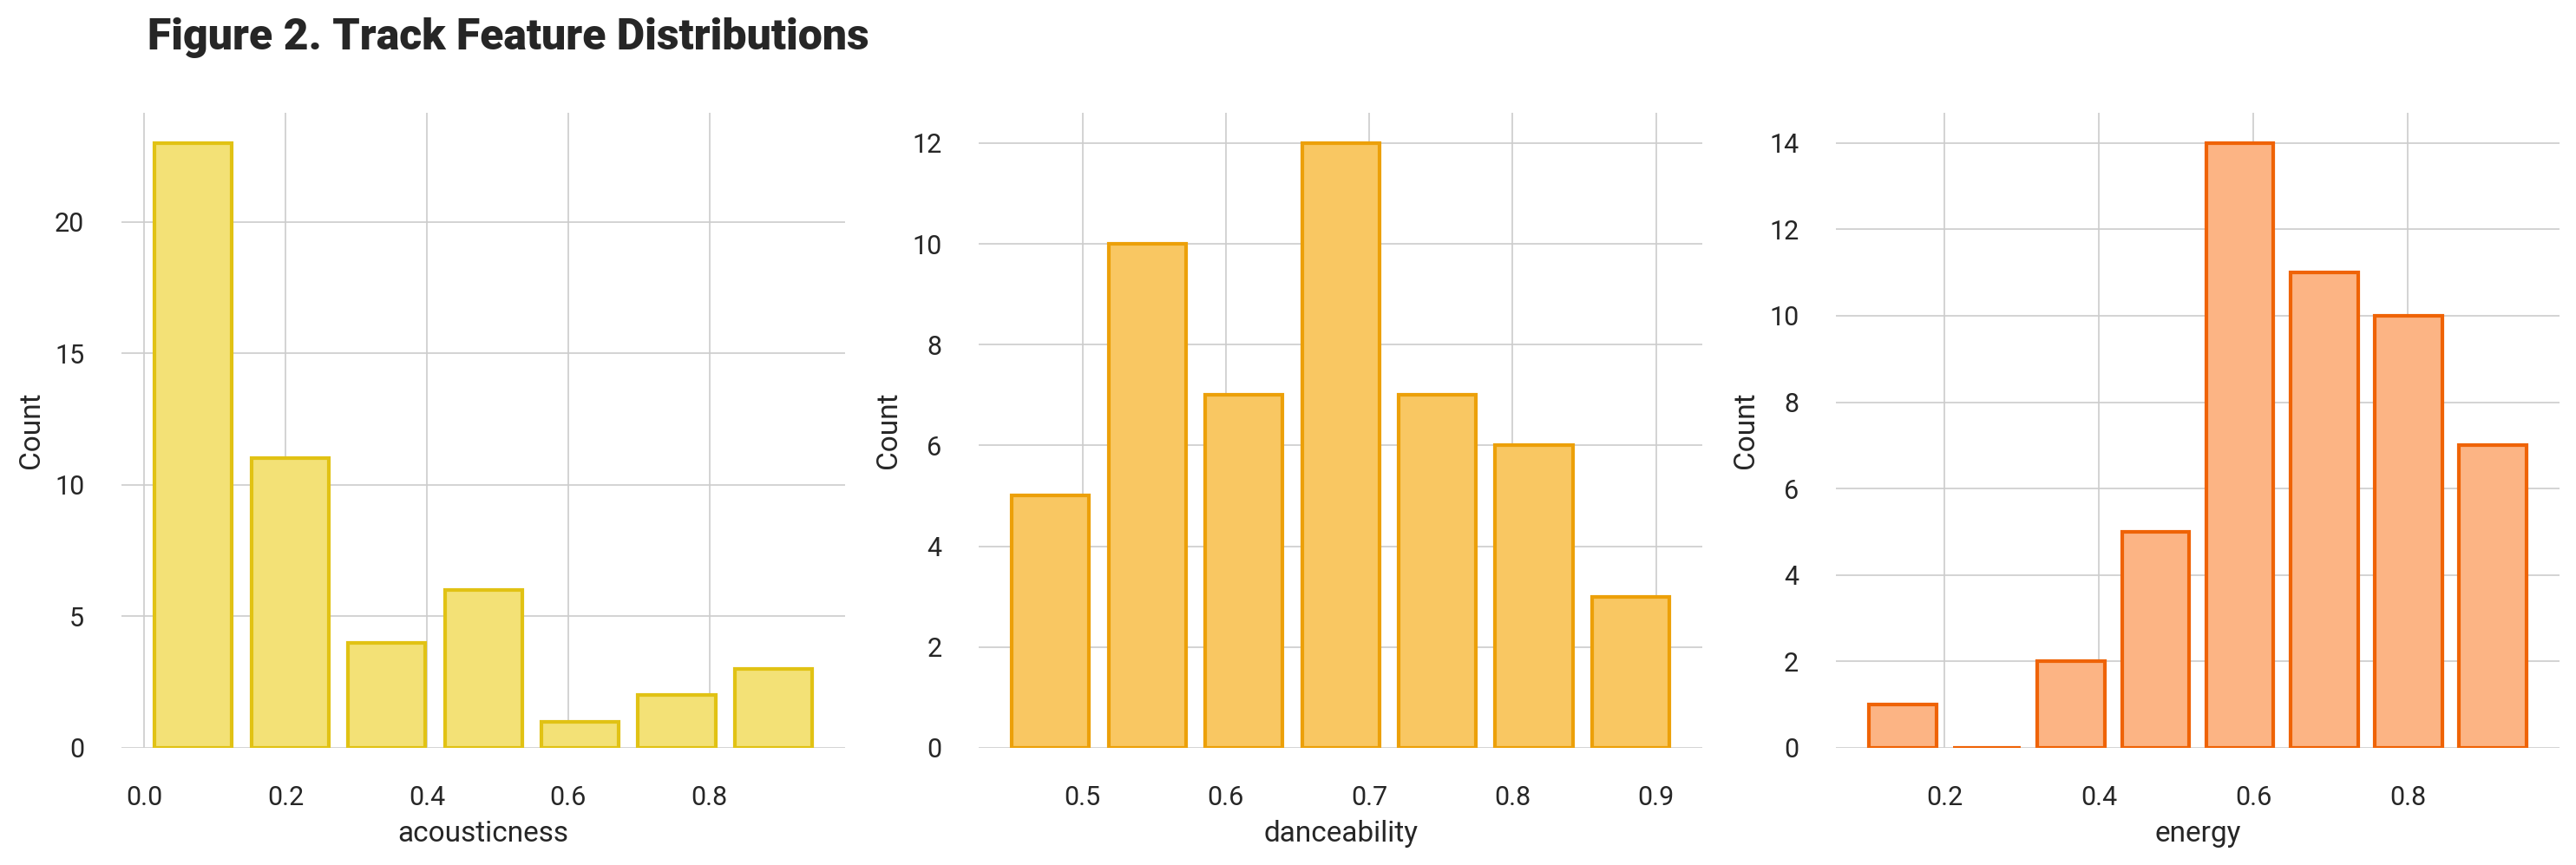

In [138]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 2. Track Feature Distributions", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=df, x=df[df["acousticness"].notnull()]["acousticness"], color="#F3E176", alpha=1.0, ax=axs[0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
sns.histplot(data=df, x=df[df["danceability"].notnull()]["danceability"], color="#F9C762", alpha=1.0, ax=axs[1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
sns.histplot(data=df, x=df[df["energy"].notnull()]["energy"], color="#FCB484", alpha=1.0, ax=axs[2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)
#axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
fig.tight_layout()
# plt.savefig("static/images/brand_dist.png", format="png", dpi=1200)
plt.show()

In [41]:
#plotly_fig2 = tls.mpl_to_plotly(fig_hist) ## convert 
#iplot(plotly_fig2)

#### Twitter-roBERTa-base for Sentiment Analysis

Now, we present a graphical representation of the results obtained from the *roBERTa-base* model "trained on roughly 58 million tweets and fine-tuned for sentiment analysis using the TweetEval benchmark" (EMNLP 2020). According to the **TweetEval** reference paper and official Github repository, the resulting labels `0`, `1`, and `2` correspond to Negative, Neutral, and Positive, respectively.

- *Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive*

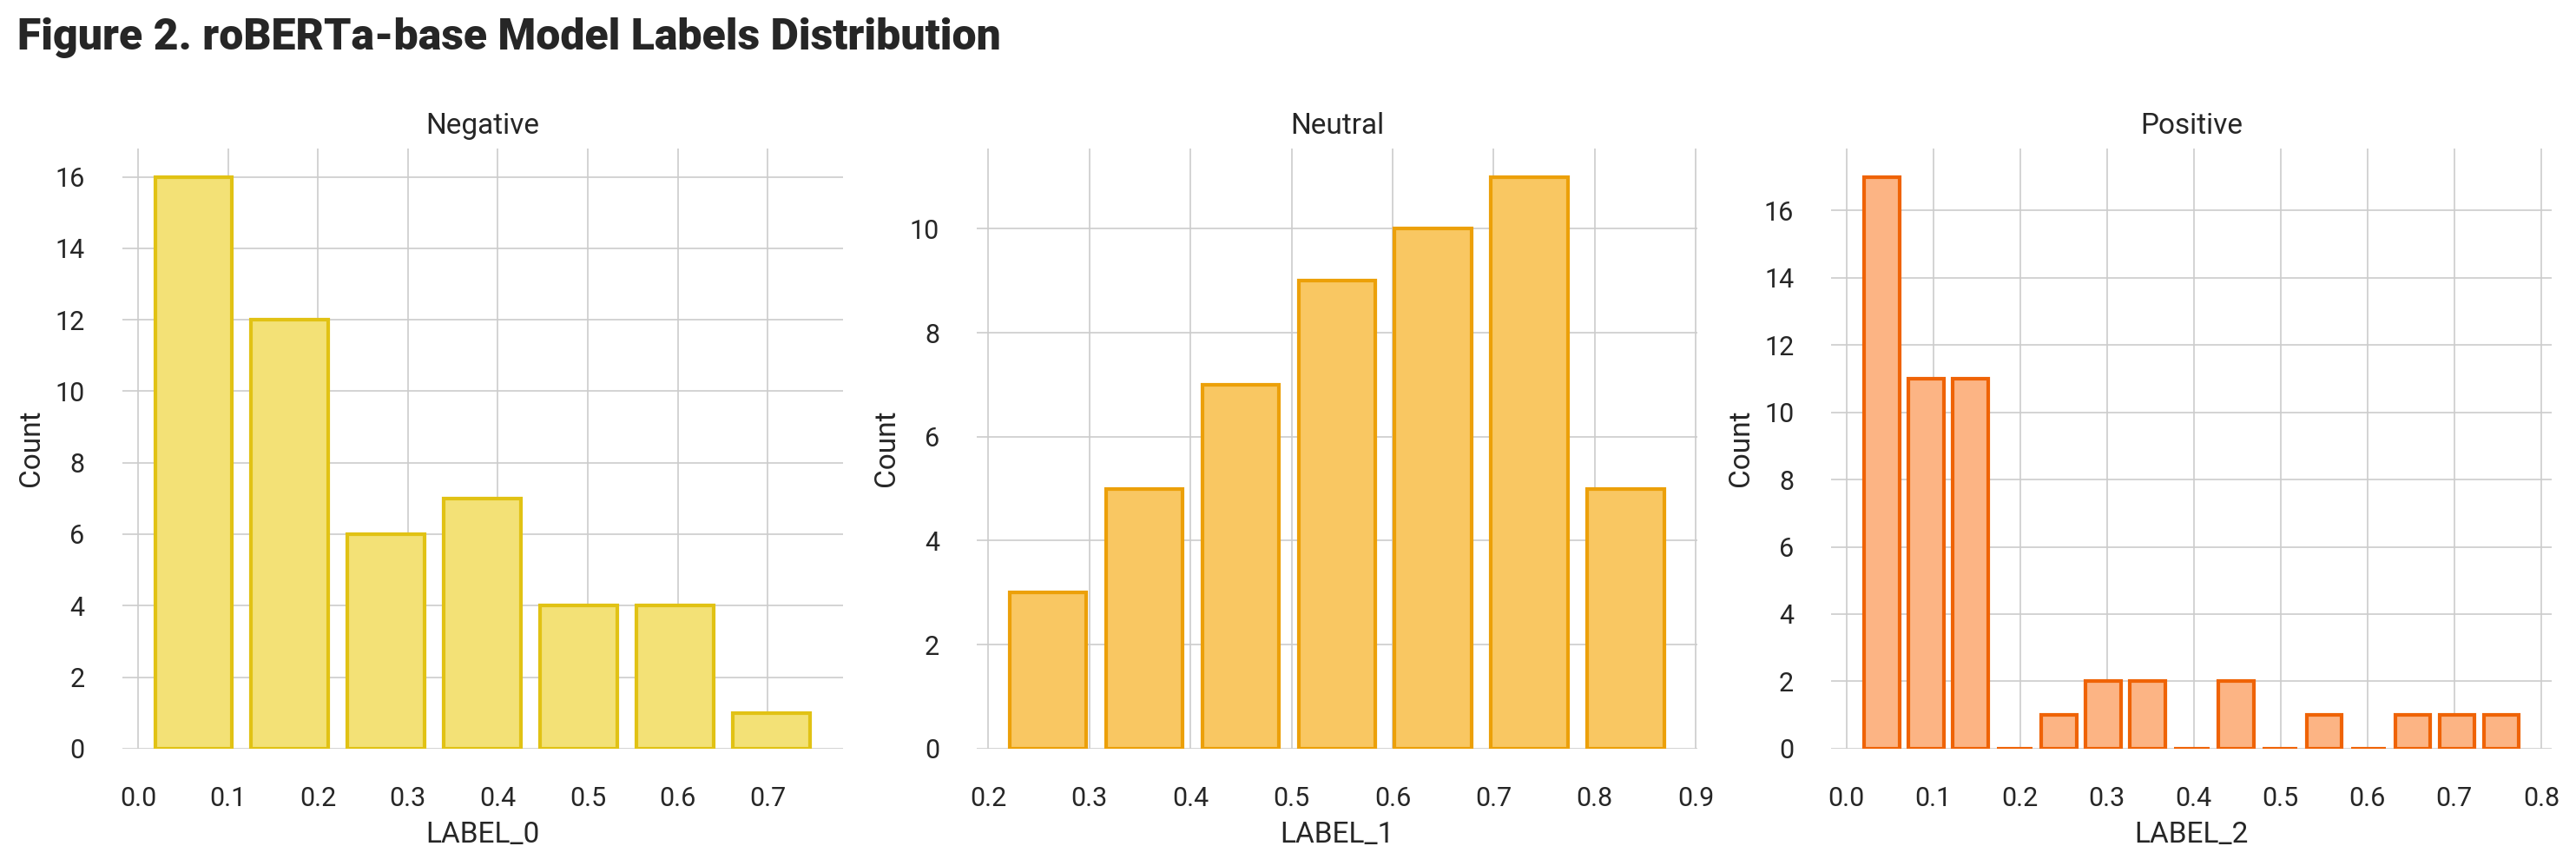

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 2. roBERTa-base Model Labels Distribution", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=df_final, x=df_final[df_final["LABEL_0"].notnull()]["LABEL_0"], color="#F3E176", alpha=1.0, ax=axs[0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
axs[0].set_title("Negative")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_1"].notnull()]["LABEL_1"], color="#F9C762", alpha=1.0, ax=axs[1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
axs[1].set_title("Neutral")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_2"].notnull()]["LABEL_2"], color="#FCB484", alpha=1.0, ax=axs[2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)
axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
fig.tight_layout()
# plt.savefig("static/images/brand_dist.png", format="png", dpi=1200)
plt.show()

This code above creates a histogram that displays the distribution of labels for a roBERTa-base model. The labels are categorized as negative, neutral, or positive, with each having its own distinct color. Additionally, the code adds a title to the figure and resizes the subplots to ensure a better fit. The final output is a graph that can be saved in png format for future reference.

### Correlations Matrix

After completing the initial data analysis, we proceed with generating the Pearson correlations matrix using the Pandas command `df.corr()`. Subsequently, we visualize the matrix using the seaborn heatmap, providing a detailed understanding of the relationships between the various variables in our dataset.


In [43]:
track_sentiment_df = df_final[['track_name', 'artist_name',
           'acousticness', 'danceability', 'energy', 'instrumentalness', 
           'loudness', 'speechiness', 'tempo', 'valence', 
           'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
           'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

# Find the pearson correlations matrix
corr = track_sentiment_df.corr(method = 'pearson')

In [44]:
plt.figure(figsize=(10,8), dpi =600)
g = sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5, annot_kws={"size": 8}, cbar_kws={"shrink": .25})

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 9,family='Roboto')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 9,family='Roboto')
plt.title('Sentiment Analysis Model Labels Correlation Matrix')

# plt.savefig('static/images/heatmap.png')              
plt.show()

In [45]:
#fig, ax = plt.subplots(figsize=(10,6))
#sns.heatmap(corr, center=0, cmap='Blues')
#ax.set_title('Multi-Collinearity of Lyric NLP Sentiment Analysis')

The code below produces a scatterplot that showcases the correlation between energy and fear. The x-axis represents the energy value, while the y-axis represents the fear sentiment. The size of each data point corresponds to the label indicating the neutral sentiment level, and its color represents the valence value. Moreover, each bubble contains its energy value within, allowing for a straightforward interpretation of the data.


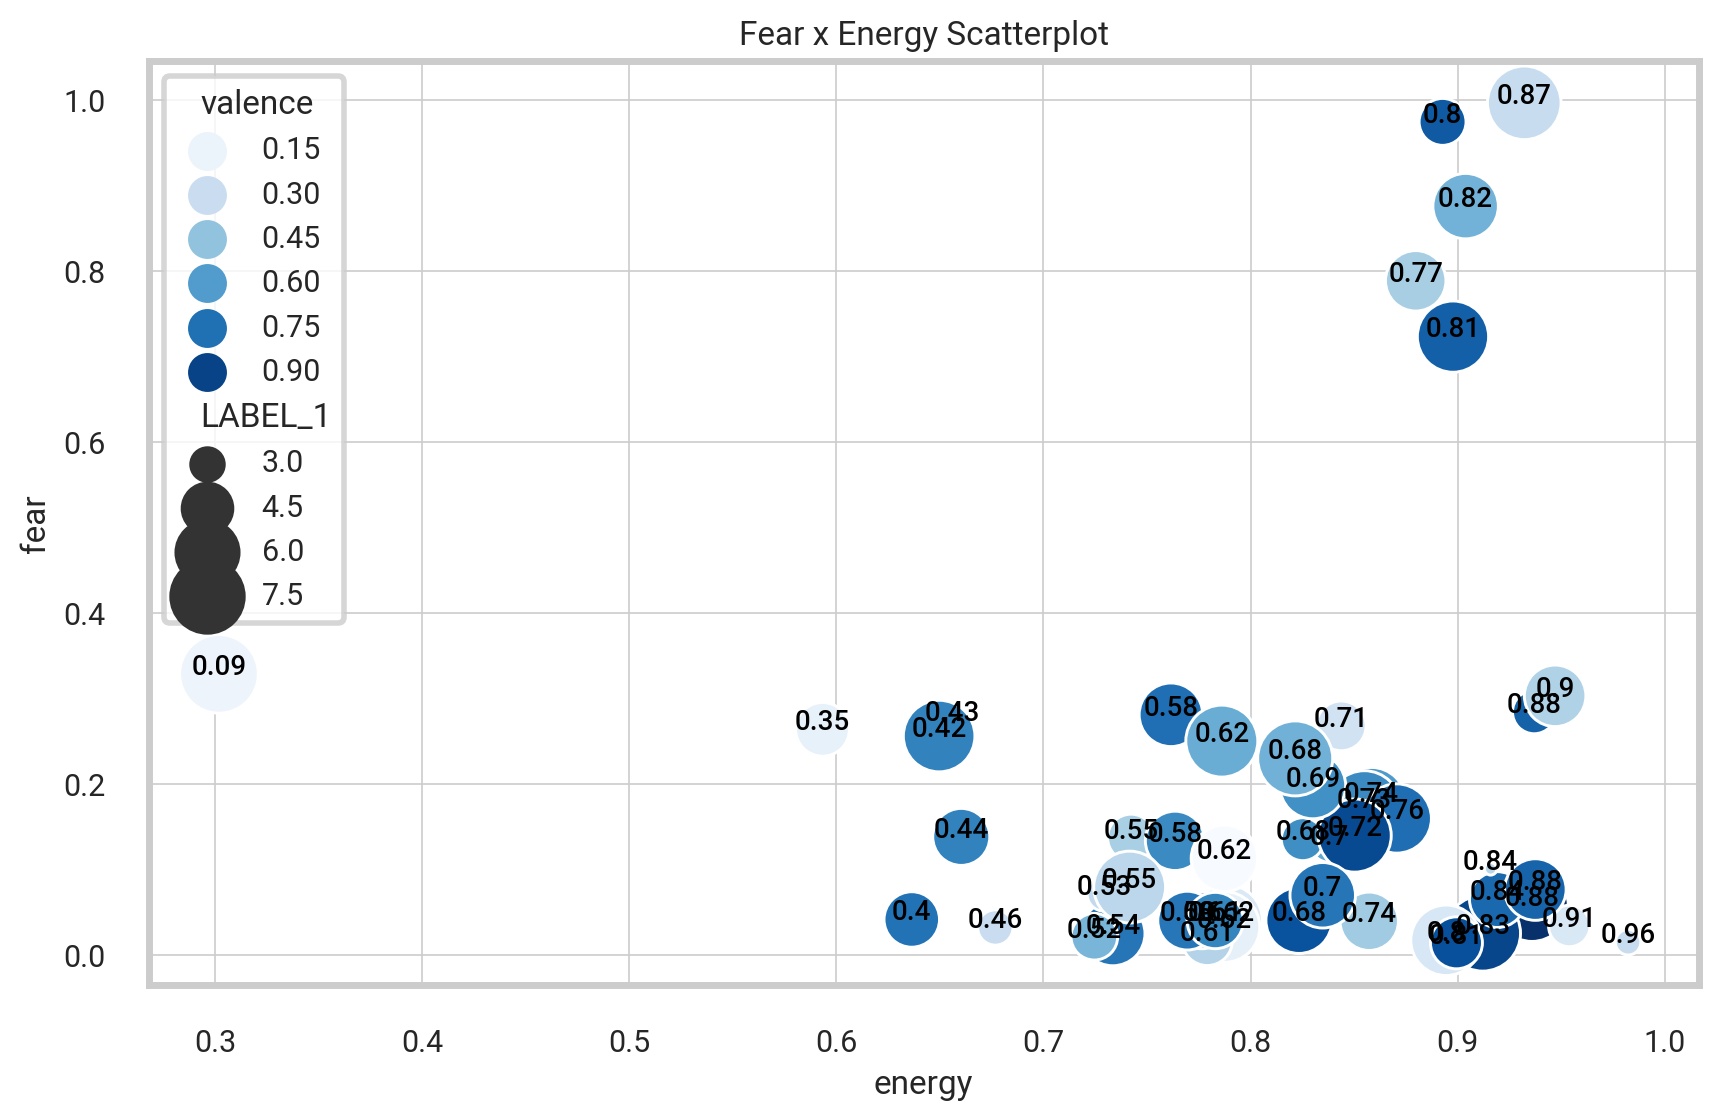

In [46]:
fig = plt.figure(figsize = (10,6), dpi=100)
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(x=track_sentiment_df['energy']**0.5, y=track_sentiment_df['fear']**0.5,
               size=track_sentiment_df['LABEL_1']*10, hue=track_sentiment_df['valence'],
               sizes=(20,800),
               palette='Blues')
#For each point, we add a text inside the bubble
for line in range(0,track_sentiment_df.shape[0]):
     ax.text(track_sentiment_df.energy[line]**0.5, track_sentiment_df.fear[line]**0.5, 
             round(track_sentiment_df.energy[line], 2), 
             horizontalalignment='center', size='small', color='black', weight='semibold')
        
plt.title('Fear x Energy Scatterplot')
#plt.savefig(title, dpi=400)
plt.show()

Text(0.5, 1.0, 'Fear vs. Energy')

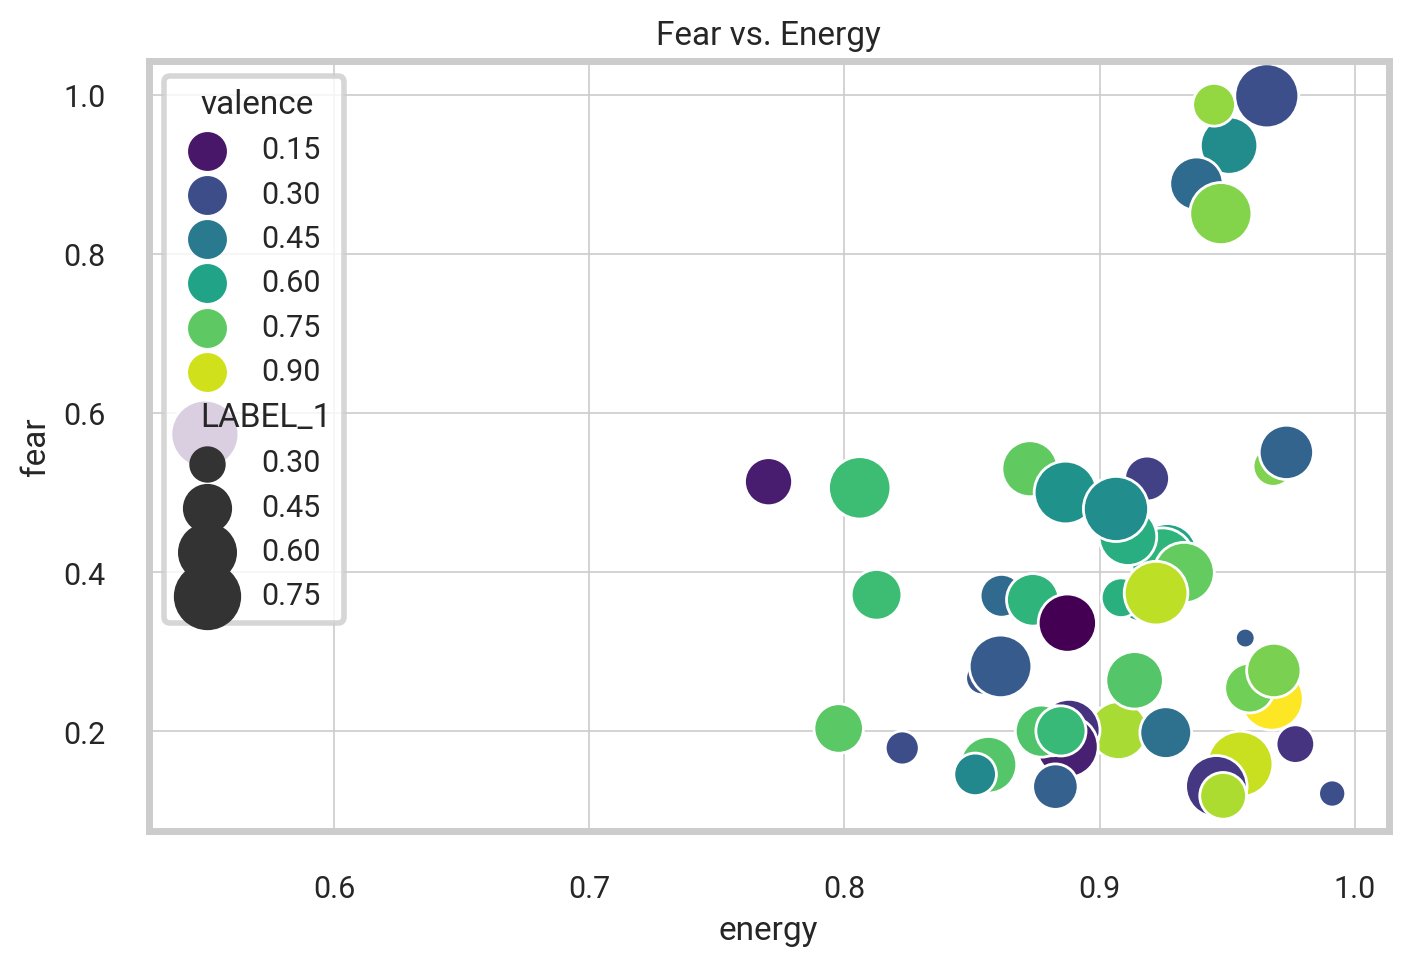

In [47]:
#fig = plt.figure(figsize = (10,6), dpi=800)
# Create scatterplot. alpha controls the opacity and s controls the size.
plot = sns.scatterplot(x = track_sentiment_df['energy']**0.25, 
                       y = track_sentiment_df['fear']**0.25,
                       hue = track_sentiment_df['valence'],
                       size = track_sentiment_df['LABEL_1'],
                       sizes = (50, 600),
                       size_order = track_sentiment_df['LABEL_1'],
                       palette = 'viridis')
plot.set_title('Fear vs. Energy')


Similarly, the scatterplot presented above utilizes the track sentiment data, comparing the energy and fear levels of the tracks based on valence and size.

------



## PCA Analysis

Next, we implement principal component analysis (PCA) on a comprehensive dataset comprising a range of musical features.

First, we create a table from the `df_final` dataframe by extracting specific columns that facilitate our analysis. These columns consist of acousticness, danceability, energy, speechiness, tempo, and valence of each track, as well as emotional features such as sadness, joy, love, anger, fear, and surprise. In addition, the table includes the track name and flags for both negative and positive sentiments.

We then perform PCA on the data in the table and apply it to generate a biplot depicting the relationship between the features and tracks. This biplot quickly reveals any discernible patterns and clusters within the dataset.


In [48]:
X_SMALL = df_final[['acousticness', 'danceability', 'energy', 'speechiness', 
                    'tempo', 'valence', 'sadness', 'joy', 'love', 'anger', 
                    'fear', 'surprise', 'track_name', 'NEGATIVE', 'POSITIVE']]

To process the data, the code employs the **PCA** and **StandardScaler** modules from the `sklearn` *decomposition* and *preprocessing* libraries. Specifically, the $X_i$ variable is used to choose the first 12 columns from the subset of data mentioned above, while the track_name column is chosen as the target variable. Next, the StandardScaler standardizes the $X_i$ data.

PCA is applied to the standardized data, $X_{st}$, using the PCA module, and the resulting loadings and eigenvalues are saved.

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster

X_i = X_SMALL.iloc[:,0:12]
target = X_SMALL['track_name'].to_numpy()
X_st =  StandardScaler().fit_transform(X_i)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_

# get eigenvalues (variance explained by each PC)  
pca_out.explained_variance_

array([2.44993210e+00, 2.00586379e+00, 1.62545521e+00, 1.41945938e+00,
       1.29500400e+00, 9.86714149e-01, 8.54648893e-01, 5.62083450e-01,
       5.13764426e-01, 3.74437738e-01, 1.57534821e-01, 1.06126388e-14])

Next, the following code uses the `PCA()` function to calculate the PCA scores of the standardized data set, $X_{st}$. 

A biplot is generated using the cluster module from the bioinfokit library. The biplot is based on the PCA scores and loadings, and the column names of the $X_i$ data frame are used as labels for the plot. The variance explained by the first two principal components are also displayed on the plot.


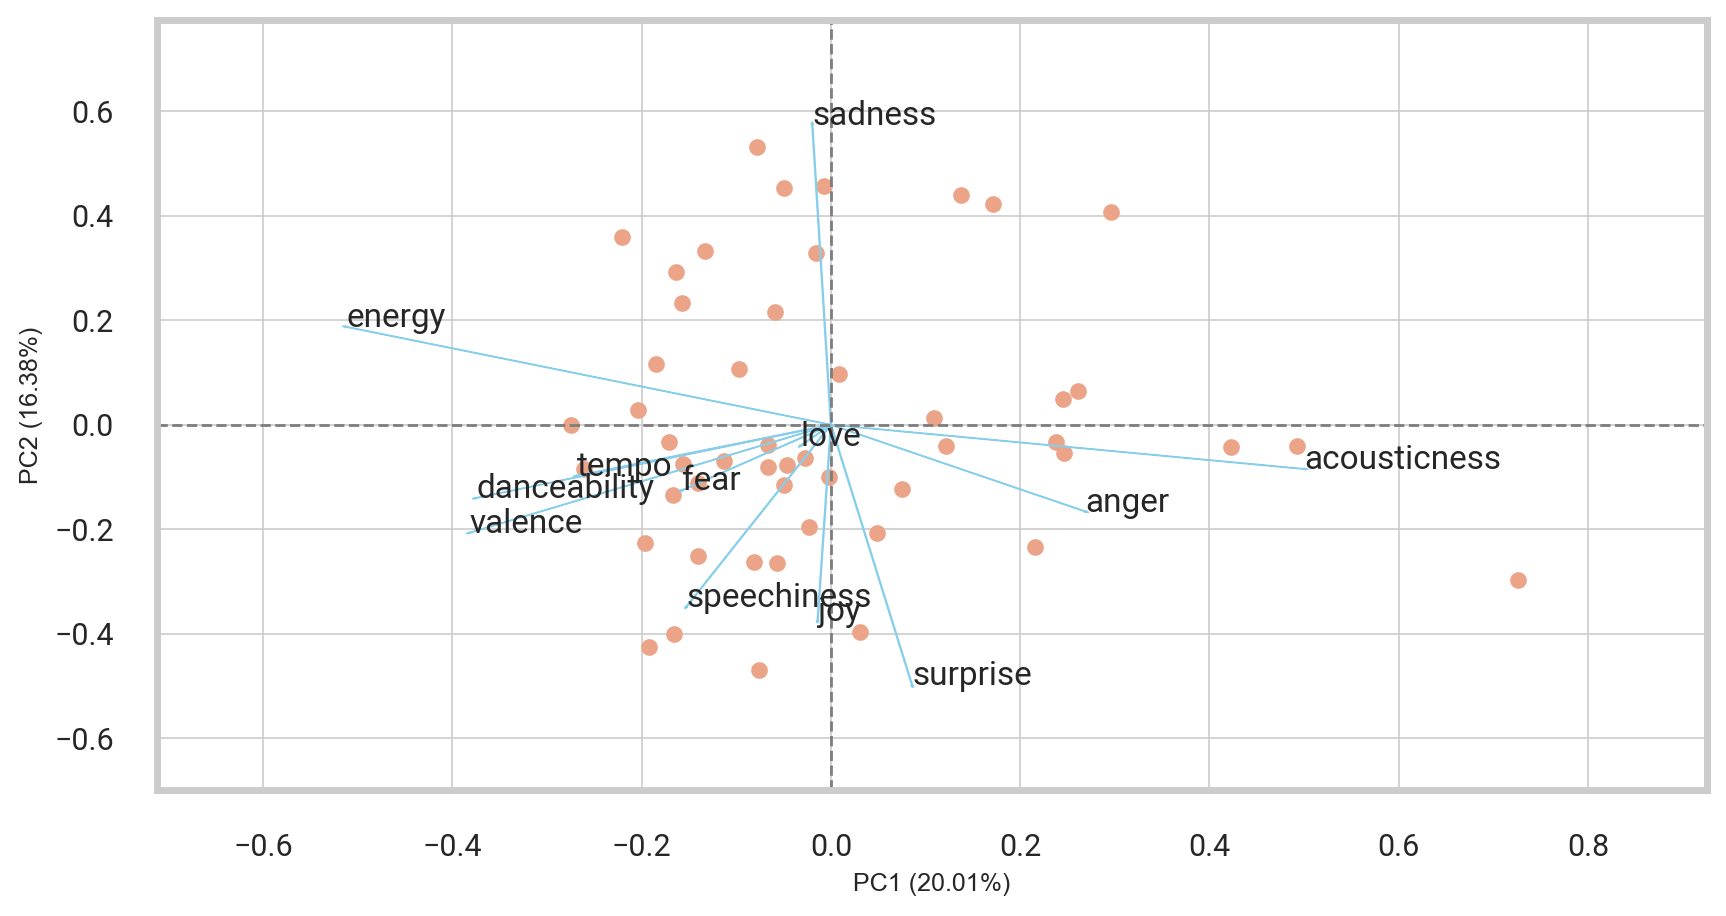

In [50]:
#| code-fold: true
# get biplot
pca_scores = PCA().fit_transform(X_st)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=X_i.columns.values, 
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2), #colorlist=target,
               show=True,dim=(10,5),dotsize=16)



Then, I assigned the resulting column names to the variable `cols_pca` using a list comprehension. Using the PCA scores, column names, and the original index from $X_i$, I created a new pandas DataFrame called `df_pca`. The first three rows of this new DataFrame is shown below.

In [51]:
#pca = PCA()
pca_scores = PCA().fit_transform(X_st)
cols_pca = [f'PC{i}' for i in range(1, pca_out.n_components_+1)]
df_pca = pd.DataFrame(pca_scores, columns=cols_pca, index=X_i.index)

In [52]:
df_pca.head(3)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.696037  2.012682 -0.346747  0.581137  0.019481 -0.517305 -0.659773   
1  0.239492 -2.221240  0.960182  1.669979  1.274440 -1.194513  0.315276   
2 -0.628016 -1.472723 -2.011198 -0.143985  1.620391  0.545348  0.329770   

        PC8       PC9      PC10      PC11          PC12  
0 -1.010507 -0.859774 -0.830831  0.047350 -6.710911e-08  
1 -1.014649  0.596109 -0.336843  0.632863  7.230154e-09  
2 -0.271807  0.868438 -0.047258  0.143655  9.459873e-08

The variance ratios for the PCA output and the cumulative sum of the explained variance ratios are printed below. Specifically, the array displayed represents the amount of variability explained by each component.

In [53]:
print(pca_out.explained_variance_ratio_)
print('----')
print(pca_out.explained_variance_ratio_.cumsum())

[2.00077788e-01 1.63812209e-01 1.32745509e-01 1.15922516e-01
 1.05758660e-01 8.05816555e-02 6.97963263e-02 4.59034818e-02
 4.19574281e-02 3.05790819e-02 1.28653437e-02 8.66698836e-16]
----
[0.20007779 0.36389    0.49663551 0.61255802 0.71831668 0.79889834
 0.86869466 0.91459815 0.95655557 0.98713466 1.         1.        ]



The loading vectors help visualize the relationship between the original variables and their respective components. These vectors represent the weights of the variables within a mathematical equation used to generate the principal components.

In [54]:
df_weights = pd.DataFrame(pca_out.components_.T, columns=df_pca.columns, index=X_i.columns)
df_weights

PC1       PC2       PC3       PC4       PC5       PC6  \
acousticness  0.500030 -0.084596 -0.163360  0.270448 -0.177716  0.044052   
danceability -0.375051 -0.140213 -0.240881  0.243561  0.371144  0.161730   
energy       -0.512299  0.187415  0.189290 -0.143689 -0.234153 -0.043121   
speechiness  -0.152676 -0.348034  0.158824  0.271103  0.513387 -0.136357   
tempo        -0.268418 -0.097683  0.294100 -0.063308 -0.317417 -0.565040   
valence      -0.381629 -0.206524 -0.312687  0.270942 -0.093002 -0.099887   
sadness      -0.019677  0.574964  0.065357  0.192931  0.342925 -0.133225   
joy          -0.014079 -0.375144 -0.384662 -0.586663  0.021737 -0.040859   
love         -0.031740 -0.039614 -0.287281  0.534846 -0.477789 -0.095453   
anger         0.268670 -0.165834  0.397815  0.097444  0.074520 -0.342894   
fear         -0.157201 -0.125263  0.452117  0.081985 -0.223934  0.689989   
surprise      0.085846 -0.498659  0.269321  0.110920  0.028643  0.003488   

                   PC7       PC8       PC9      PC10      PC11          PC12  
acousticness -0.252778 -0.350158  0.188205  0.057071  0.619900 -8.689746e-09  
danceability  0.248108 -0.285684  0.070302  0.636896  0.068382  2.450921e-08  
energy        0.206090  0.067551 -0.241475 -0.083951  0.690556 -8.037493e-09  
speechiness  -0.085688  0.370286  0.390224 -0.344426  0.243562 -2.791231e-08  
tempo        -0.349210 -0.155539  0.380321  0.321268 -0.117840  1.416773e-09  
valence      -0.175265 -0.487846 -0.235667 -0.518987 -0.168225 -2.464885e-08  
sadness      -0.359329 -0.037474 -0.170799  0.040270  0.015622  5.750036e-01  
joy          -0.039045  0.039482  0.065842 -0.000493  0.110312  5.875391e-01  
love          0.219246  0.470088  0.027763  0.093162 -0.081110  3.261260e-01  
anger         0.612351 -0.341016 -0.096755 -0.098445 -0.035783  3.127856e-01  
fear         -0.092791 -0.141514  0.240922 -0.067893 -0.104814  3.463513e-01  
surprise     -0.331315  0.177899 -0.668719  0.261279  0.037608  4.051205e-03

--------------

## Spotify Songs - Similarity Search




Below, we create a query to retrieve similar elements based on Euclidean distance. In mathematics, the Euclidean distance between two points is the length of the line segment between the two points. In this sense, the closer the distance is to 0, the more similar the songs are.



#### [KNN Algorithm](https://www.kaggle.com/code/leomauro/spotify-songs-similarity-search/notebook)


To obtain a string search for a song, utilize the `getMusicName` function shown below, which returns the artist and song name. 

The k-Nearest Neighbors (KNN) algorithm searches for k similar elements based on a query point at the center within a predefined radius. We execute the KNN algorithm using the `knnQuery` function defined below, which takes a query point, a set of characteristic points, and a value for k. It computes the sum of squared differences between each data and query point, followed by the calculation of the Euclidean distance between them. The function then arranges the points by distance and returns the k closest and farthest points.

The `querySimilars` function then removes the query point and executes the KNN algorithm on the remaining points, returning the k most similar points to the query point based on the specified columns, function, and parameter.




In [55]:
# Get a song string search
def getMusicName(elem):
    return f"{elem['artist']} - {elem['name']}"

def knnQuery(queryPoint, arrCharactPoints, k):
    queryVals = queryPoint.tolist()
    distVals = []
    
    # Copy of dataframe indices and data
    tmp = arrCharactPoints.copy(deep = True)  
    for index, row in tmp.iterrows():
        feat = row.values.tolist()
        
        # Calculate sum of squared differences
        ssd = sum(abs(feat[i] - queryVals[i]) ** 2 for i in range(len(queryVals)))
        
        # Get euclidean distance
        distVals.append(ssd ** 0.5)
        
    tmp['distance'] = distVals
    tmp = tmp.sort_values('distance')
    
    # K closest and furthest points
    return tmp.head(k).index, tmp.tail(k).index


# Execute KNN removing the query point
def querySimilars(df, columns, idx, func, param):
    arr = df[columns].copy(deep = True)
    queryPoint = arr.loc[idx]
    arr = arr.drop([idx])
    return func(queryPoint, arr, param)

**KNN Query Example.** 

We now establish a function that creates customized query points and alters the data columns, allowing for further exploration of various options. To illustrate, the code snippet below chooses a particular group of song features and then seeks out the top k values within that feature set that are equal to one.

To begin, we create a scaler utilizing the preprocessing library from *sklearn*. It's worth noting that all the feature values fall within the range of 0 and 1, except for loudness. As a result, we need to scale loudness to conform to the same range.

In [56]:
from sklearn import preprocessing 

scaler = preprocessing.MinMaxScaler()
# scale loudness to fit the same range [0, 1]
loudness2 = df["loudness"].values
loudness_scaled=scaler.fit_transform(loudness2.reshape(-1, 1))
df['loudness_scaled'] = loudness_scaled

Let's search for  $k=3$  similar songs to a query point $\textrm{songIndex} = 6$. 

In [57]:
# Select song and column attributes
songIndex = 4 # query point
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
           'loudness_scaled', 'tempo', 
           'speechiness', 'valence']

# Set query parameters
func, param = knnQuery,3

# Implement query
response = querySimilars(df, columns, songIndex, func, param)

print("---- Query Point ----")
print(getMusicName(df.loc[songIndex]))
print('---- k = 3 similar songs ----')
for track_id in response[0]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)
print('---- k = 3 nonsimilar songs ----')
for track_id in response[1]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)

---- Query Point ----
Olivia Rodrigo - bad idea right?
---- k = 3 similar songs ----
Peggy Gou - (It Goes Like) Nanana - Edit
Gunna - fukumean
David Kushner - Daylight
---- k = 3 nonsimilar songs ----
V - Love Me Again
The Weeknd - Die For You - Remix
Morgan Wallen - Last Night


The code below implements the same idea as above, but queries each track in a given playlist instead of a single defined query point.

To keep track of the number of songs that are similar and those that are not, we use two dictionaries: similar_count" and "nonsimilar_count". To do this, we create a loop that goes through the data, running the `querySimilars` function on each track. A loop then processes "similar" and "non-similar" songs from the results of the query, stored in the "response" variable. If a "similar" song is found, its name is retrieved using the `getMusicName` function. The song's name is then added to the "similar_count" dictionary with a count of 1, or incremented if it already exists.

The same process is repeated for the "non-similar" songs, except the count is added to the "nonsimilar_count" dictionary instead.

In [58]:
similar_count = {} # Similar songs count
nonsimilar_count = {} # Non-similar songs count

for track_index in df.index:
    # Implement query
    response = querySimilars(df, columns, track_index, func, param)
    
    # Get similar songs
    for similar_index in response[0]:
        track = getMusicName(df.loc[similar_index])
        if track in similar_count:
            similar_count[track] += 1
        else:
            similar_count[track] = 1
    
    # Get non-similar songs
    for nonsimilar_index in response[1]:
        track = getMusicName(df.loc[nonsimilar_index])
        if track in nonsimilar_count:
            nonsimilar_count[track] += 1
        else:
            nonsimilar_count[track] = 1

Next, we display both the non-similar and similar songs with their respective track name and count.

In [59]:
#| code-fold: true

nonsimilar = dict(sorted(nonsimilar_count.items(), key=lambda item: item[1], reverse=True))
print('---- NON SIMILAR SONG COUNTS ----')
for track_name, track_count in nonsimilar.items():
    if track_count >= 8:
        print(track_name, ':', track_count)

similar = dict(sorted(similar_count.items(), key=lambda item: item[1], reverse=True))
print('\n---- SIMILAR SONG COUNTS ----')
for track_name, track_count in similar.items():
    if track_count >= 5:
        print(track_name, ':', track_count)

---- NON SIMILAR SONG COUNTS ----
Morgan Wallen - Last Night : 38
The Weeknd - Die For You - Remix : 29
V - Love Me Again : 28
Harry Styles - As It Was : 22
Charli XCX - Speed Drive (From Barbie The Album) : 21
Billie Eilish - What Was I Made For? [From The Motion Picture "Barbie"] : 12

---- SIMILAR SONG COUNTS ----
Olivia Rodrigo - bad idea right? : 5
Gunna - fukumean : 5
David Kushner - Daylight : 5
Lil Durk - All My Life (feat. J. Cole) : 5
SZA - Snooze : 5
Quevedo - Columbia : 5
Doechii - What It Is (Solo Version) : 5
Charli XCX - Speed Drive (From Barbie The Album) : 5
Doja Cat - Paint The Town Red : 5


As shown above, the code snippet arranges the "nonsimilar_count" dictionary in a descending sequence, followed by presenting the tracks with the highest non-similar query counts. We repeat the same process for songs that are similar from the "similar_count" dictionary.



----------------------

## Organized Songs in a Playlist


Below, we import the Python pandas, matplotlib.pyplot, and sklearn libraries to our project. These tools help us perform various operations such as clustering, decomposition, and data visualization.

We then obtain a list of songs including their name and various attributes such as acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence, and loudness. Next, we gather helpful insights about these songs using the' describe' function.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition

songs = df[['name','acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'tempo', 'valence',  'loudness_scaled']]
songs.describe()

acousticness  danceability     energy  instrumentalness   liveness  \
count     50.000000     50.000000  50.000000         50.000000  50.000000   
mean       0.244202      0.666340   0.669182          0.023736   0.178292   
std        0.256028      0.114361   0.171171          0.094858   0.133537   
min        0.001260      0.444000   0.091100          0.000000   0.032200   
25%        0.053300      0.563500   0.580750          0.000000   0.095425   
50%        0.146500      0.665500   0.685000          0.000006   0.114000   
75%        0.378750      0.741500   0.804500          0.000162   0.230750   
max        0.959000      0.916000   0.965000          0.629000   0.671000   

       speechiness       tempo    valence  loudness_scaled  
count    50.000000   50.000000  50.000000        50.000000  
mean      0.080464  124.506220   0.543378         0.784907  
std       0.074471   28.585249   0.238465         0.162639  
min       0.025400   66.900000   0.096900         0.000000  
25%       0.036300  100.312500   0.328500         0.722074  
50%       0.053200  126.987000   0.585500         0.823084  
75%       0.079600  140.819750   0.740250         0.866962  
max       0.351000  203.853000   0.964000         1.000000

Extracting the song labels from the dataset is the first crucial step. Then, we must select the appropriate features that will serve as inputs for the Affinity Propagation clustering algorithm from the *scikit-learn* library. During the clustering process, a preference value of -200 is used to ensure optimal performance. Once the data is inputted, the algorithm is trained to achieve the desired outcome.

In [61]:
labels = songs.values[:,0]
X = songs.values[:,1:10]
kmeans = cluster.AffinityPropagation(preference=-200)
kmeans.fit(X)

AffinityPropagation(preference=-200)

The script below utilizes a dictionary called "predictions" to keep track of the outcomes of a comparison process between two lists: "kmeans.predict(X)" and "labels". For each new value, a unique key is generated in the dictionary with the corresponding value from the "labels" list appended to the key's list of values.

After sorting all values into their designated keys, we proceed to display each key alongside its relevant values. The output displays each category and the corresponding songs it contains.

In [62]:
predictions = {}
for p,n in zip(kmeans.predict(X),labels):
    if not predictions.get(p):
        predictions[p] = []
        
    predictions[p] += [n]

for p in predictions:
    print("Category",p)
    print("-----")
    for n in predictions[p]:
        print(n)
    print("")

Category 4
-----
(It Goes Like) Nanana - Edit
Seven (feat. Latto) (Explicit Ver.)
bad idea right?
fukumean
Daylight
Boy's a Liar Pt. 2
Baby Don't Hurt Me
People
I'm Good (Blue)
Rush
Here With Me

Category 3
-----
Barbie World (with Aqua) [From Barbie The Album]
Super Shy
vampire
WHERE SHE GOES
All My Life (feat. J. Cole)
I Ain't Worried
Moonlight
Snooze
Sprinter
Nonsense
Miracle (with Ellie Goulding)

Category 0
-----
Paint The Town Red
Popular (with Playboi Carti & Madonna) - Music from the HBO Original Series
LALA
Kill Bill
Creepin' (with The Weeknd & 21 Savage)
Columbia
Fast Car
Say Yes To Heaven
Karma
Until I Found You (with Em Beihold) - Em Beihold Version

Category 2
-----
Cruel Summer
As It Was
Chemical
What It Is (Solo Version)
Speed Drive (From Barbie The Album)

Category 5
-----
Dance The Night (From Barbie The Album)
MELTDOWN (feat. Drake)
Calm Down (with Selena Gomez)
Flowers
K-POP
Cupid - Twin Ver.
CUFF IT
Dial Drunk (with Post Malone)

Category 1
-----
What Was I Made For

The script successfully categorized the playlist into 6 distinct groups based on shared features, resulting in a diverse selection of songs within each category.

------------------------------

#### K Means Clustering


Using K Means clustering, we choose to [break the playlist into 3 smaller playlists](https://github.com/ankushbharadwaj/reorganize-my-spotify-playlist/blob/master/reorder%20my%20spotify%20playlist.ipynb).

As shown below, we employ the KMeans algorithm, obtained from the *sklearn.cluster* library, to cluster a collection of songs into distinct categories based on track features, such as their energy levels and sound qualities. Using three clusters, we apply this algorithm on the track features from the "playlist_tracks" subset of data, dropping the "artist" and "name" columns.




In [63]:
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
playlist_tracks = df[['artist','name','acousticness','danceability','energy',
                      'liveness', 'instrumentalness','speechiness','valence']]

kmeans = KMeans(n_clusters = 3)
kmeans.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))

KMeans(n_clusters=3)

Additionally, we import the "seaborn" library and use the "%matplotlib inline" command to generate useful plots displayed inline. Below, we generate a count plot with x-axis values set to a list of groups, displayed as string representations, produced by the k-means clustering algorithm.


<AxesSubplot:ylabel='count'>

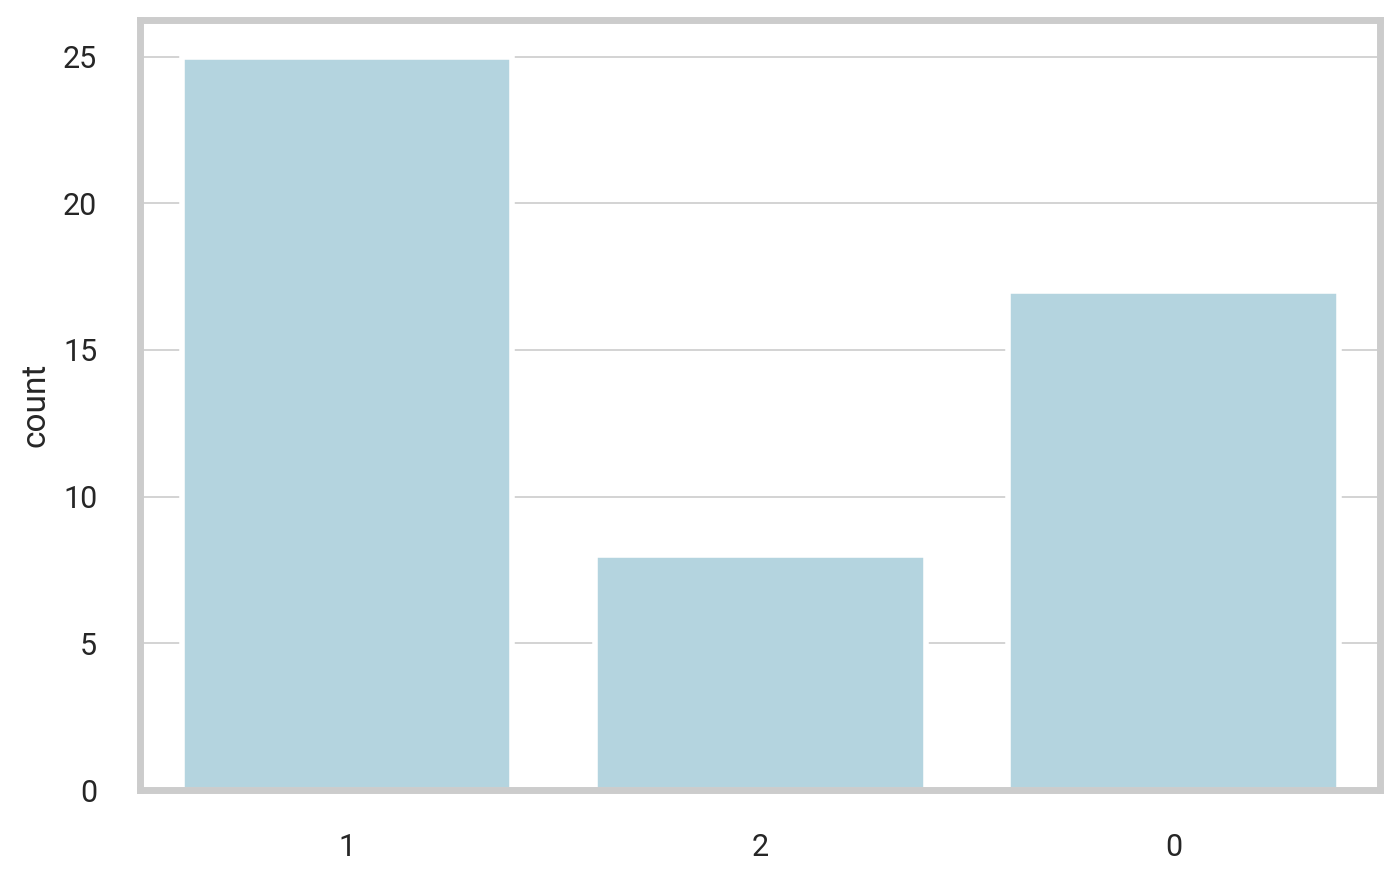

In [64]:
sns.countplot(x=[str(group) for group in kmeans.labels_], color = 'lightblue')

#### Visualizing the Clusters


Moving forward, let's look at differences in the audio features of each group.



In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))
scaled_data = scaler.transform(playlist_tracks.drop(['artist', 'name'], axis = 1))

Text(0, 0.5, 'PC2: 0.207')

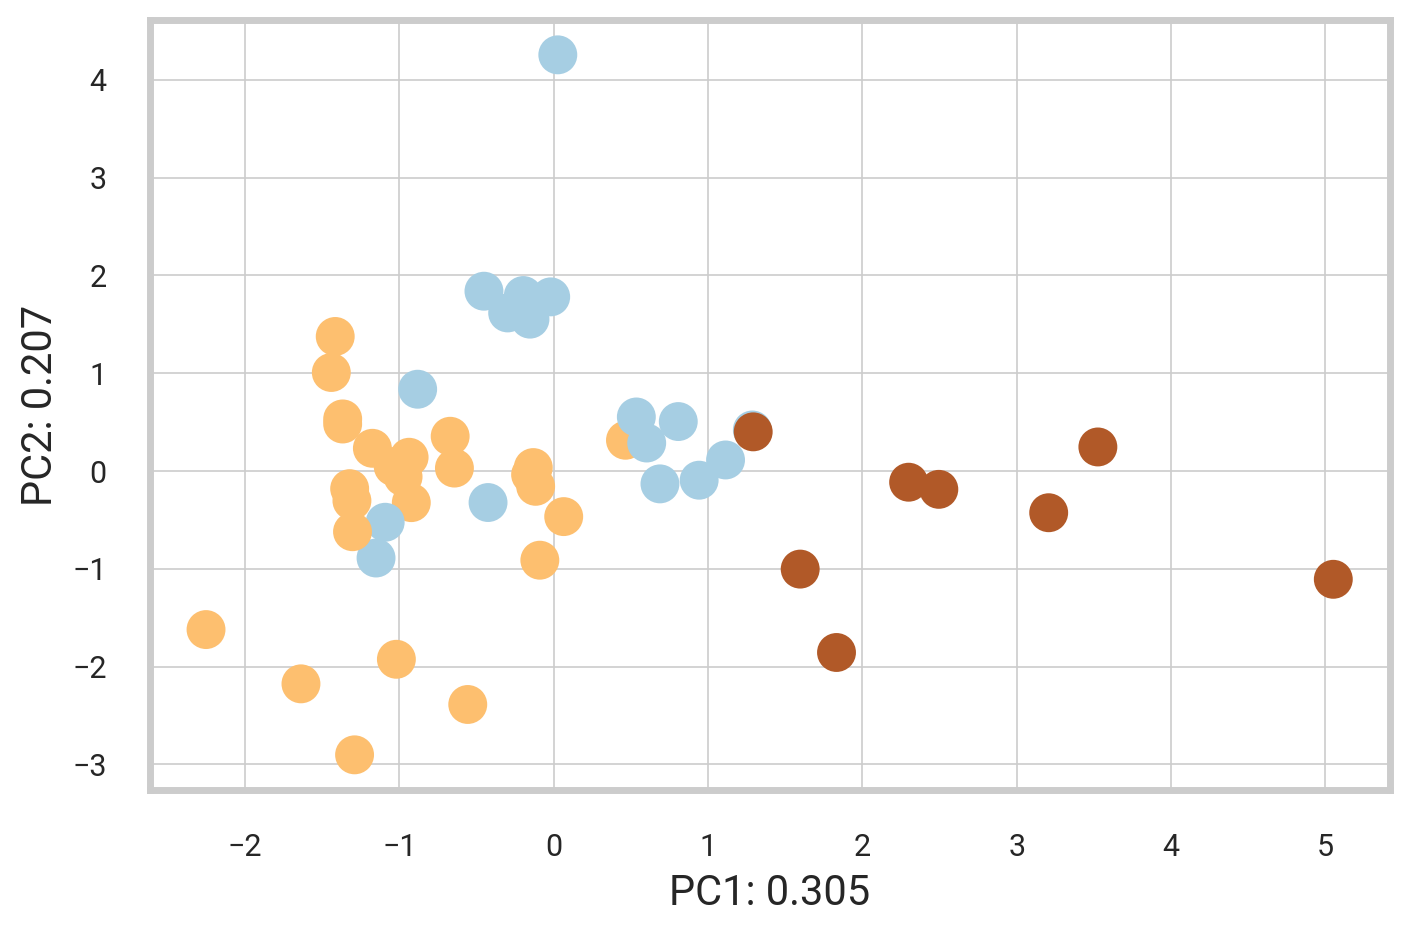

In [66]:
#| code-fold: true

from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

plt.scatter(data_pca[:,0], data_pca[:,1], c = list(kmeans.labels_), cmap = 'Paired')
plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)

Text(0, 0.5, 'PC2: 0.207')

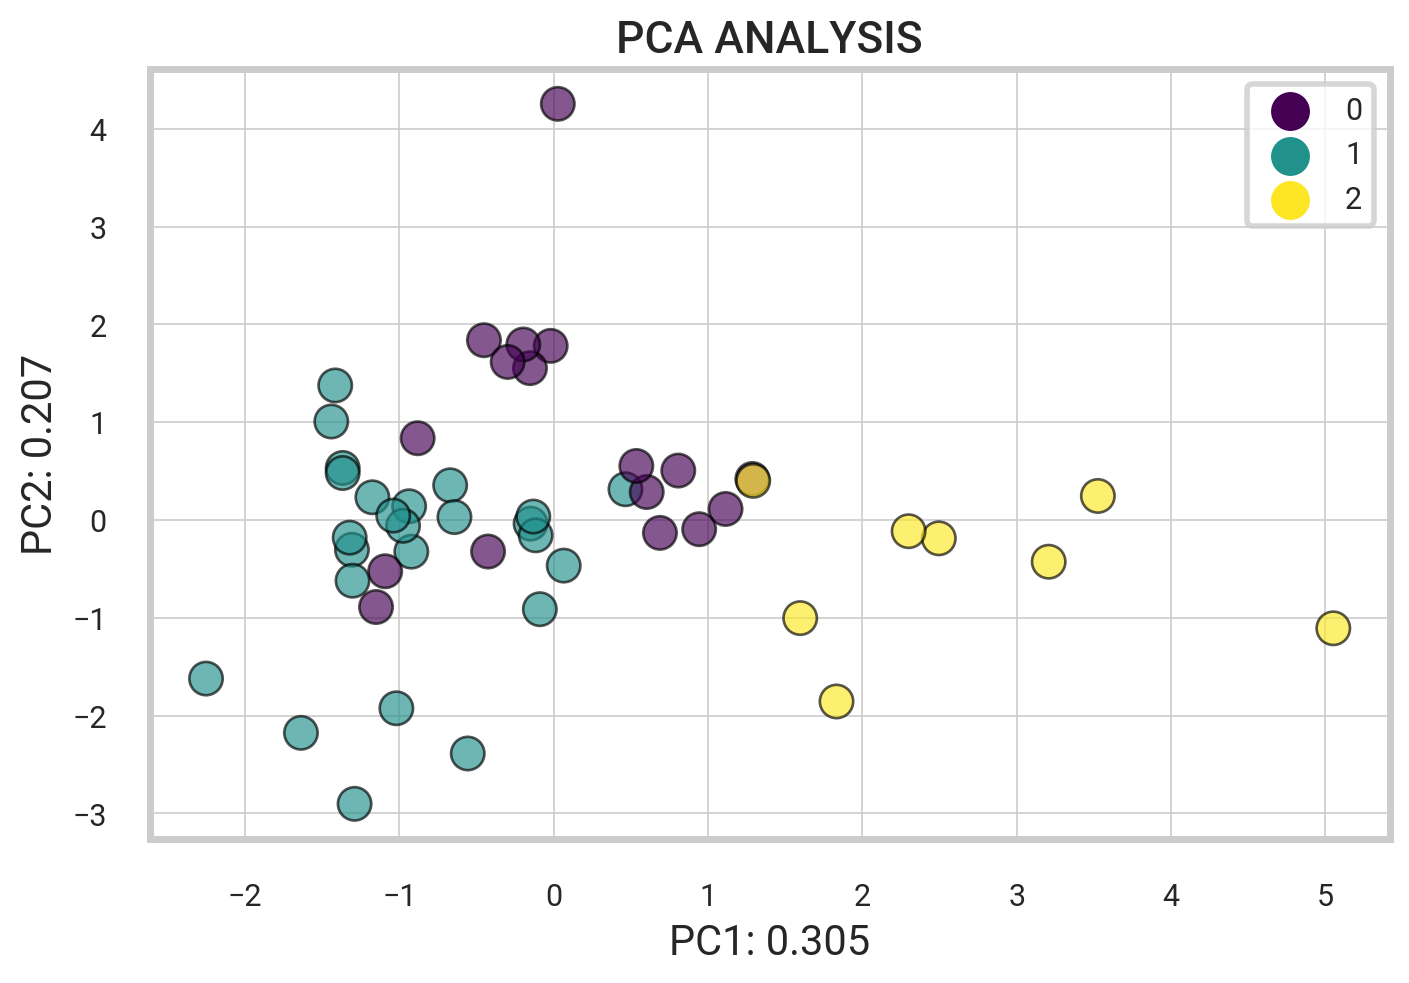

In [67]:
plot = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue = list(kmeans.labels_),
                       alpha = 0.66, 
                       #size = data_pca[:,1], sizes = (50,200),
                       palette = 'viridis', edgecolor = 'black', cmap='Paired')
plot.set_title('PCA ANALYSIS', size = 16, weight='bold')

plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)


In [68]:
playlist_tracks['group'] = list(kmeans.labels_)
playlist_tracks = playlist_tracks.astype({'group': str})

means = pd.DataFrame(index = range(0,3), 
                    columns = list(playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean'].index))
means.iloc[0] = playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean']
means.iloc[1] = playlist_tracks[playlist_tracks['group'] == '1'].describe().loc['mean']
means.iloc[2] = playlist_tracks[playlist_tracks['group'] == '2'].describe().loc['mean']
means

acousticness danceability    energy  liveness instrumentalness speechiness  \
0     0.117436        0.636  0.717412  0.242529         0.048109    0.075188   
1     0.180308      0.72748    0.7152  0.151944         0.011281      0.0967   
2      0.71325      0.53975  0.422888  0.124125         0.010864    0.040938   

    valence  
0  0.321935  
1   0.73876  
2  0.403375